<a name='home'></a>
## Content

<ul>
    <li><a href='#0'>0) Initial Project Set-up</a></li>
    <li><a href='#1'>1) Import Library</a></li>
    <li><a href='#2'>2) Import Data</a></li>
    <li><a href='#3'>3) Data Exploration (and Preparation)</a></li>
    <ul>
        <li><a href='#3.1'>3.1 Data Exploration</a></li>
        <li><a href='#3.2'>3.2 Data Preparation</a></li>
    </ul>
    <li><a href='#4'>4) Modeling</a></li>
    <ul>
        <li><a href='#4.1'>4.1 Experiment 1 - Image only, Transfer Learning (MobileNet)</a></li>
        <li><a href='#4.2'>4.2 Experiment 2 - Image only, Transfer Learning (MobileNet) : open last layer(s)</a></li>
        <ul>
            <li><a href='#4.2.1'>4.2.1 Open last Conv2D Layer for training</a></li>
            <li><a href='#4.2.2'>4.2.2 Open last Conv2D Layer for training (Dropout, Early Stopping, Lower learning rate)</a></li>
            <li><a href='#4.2.3'>4.2.3 Open last 2 blocks and Conv2D Layer for training (Dropout, Early Stopping, Lower learning rate)</a></li>
        </ul>
        <li><a href='#4.3'>4.3 Error Analysis (on misclassified examples)</a></li>
        <li><a href='#4.4'>4.4 Experiment 3 - Inclluding text data for classification</a></li>
        <ul>
            <li><a href='#4.4.1'>4.4.1 Data Exploration (Text) and Preprocessing</a></li>
            <li><a href='#4.4.2'>4.4.2 Add pre-trained Embedding layer (from Word2Vec model)</a></li>
            <ul>
                <li><a href='#4.4.2.1'>4.4.2.1 Initial Modeling</a></li>
                <li><a href='#4.4.2.2'>4.4.2.2 Adding  Dropout</a></li>
                <li><a href='#4.4.2.3'>4.4.2.3 Model Final Version</a></li>
            </ul>
            <li><a href='#4.4.3'>4.4.3 Pre-trained Embedding layer (from Word2Vec model) with GRU units</a></li>
            <ul>
                <li><a href='#4.4.3.1'>4.4.3.1 Checkpoint</a></li>
                <li><a href='#4.4.3.2'>4.4.3.2 Final Version (continue from checkpoint)</a></li>
            </ul>
        </ul>
    </ul>
    <li><a href='#5'>5) Model Selection (Summary)</a></li>
    <li><a href='#6'>6) Model Evaluation (Testing Set)</a></li>
    <li><a href='#7'>7) Model Prediction</a></li>
</ul>

<a name='0'></a>
## 0) Initial Project set-up

- Details :
- Data Sources : 
- Metrics : **Precision** (main focus), Recall, F1-Score
- Human Level Performance : 98% Approx. (on Accuracy)
- Train-Dev-Test : 65\:15\:20, stratified by label (could be nice if possible to stratified by each spam type), cross-validation (if possible)
  - Train : train model
  - Dev : validation, model selection
  - Test : testing accuracy on unseen set
- Error Analysis : 100 images hold-out validation set (fixed)
- Images and Text : use Transfer Learning


<a href='#home'>[content]</a>

<a name='1'></a>
## 1) Import Library

<a href='#home'>[content]</a>

In [ ]:
import os
import re
import math
import itertools
from datetime import datetime
from typing import Set, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score as precision_score_sk,
    recall_score as recall_score_sk,
    f1_score
)
import tensorflow as tf
import keras
import keras.backend as K
from pythainlp.tokenize import word_tokenize
from pythainlp.util.trie import dict_trie
from pythainlp.corpus.common import thai_words
from pythainlp.corpus import thai_stopwords
from gensim.models import KeyedVectors
from nltk.corpus import words as eng_words, stopwords as eng_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [2]:
print(tf.__version__)

2.11.0


In [3]:
np.set_printoptions(precision=4)

In [4]:
# constant (and cfg)
# path (and folders)
SOURCE_DIR = r"C:\Users\11413929\OneDrive - Bank of Ayudhya Public Company Limited\Desktop\Work\Other\promotion_classifier_data"
TRAIN_IMG_FOLDER = "training_images"
TEST_IMG_FOLDER = "testing_images"
TRAIN_LABEL_FILENAME = "training_set.csv"
TRAIN_LABEL_FILENAME_ADDITIONAL = "training_set_additional.csv"
TEST_PREDICT_FILENAME = "testing_set.csv"

# training cfg
BATCH_SIZE = 32
IMG_SIZE = 224
INITIAL_LEARNING_RATE = .0001
INITIAL_EPOCH = 12
RANDOM_SEED = 99

TRAINING_SPLIT = .65
VALIDATION_SPLIT = .15
TESTING_SPLIT = .2

In [5]:
# checking
total_percentage = TRAINING_SPLIT + VALIDATION_SPLIT + TESTING_SPLIT

assert total_percentage == 1, f"Total percentage for train-test split should be 1, got {total_percentage}"

In [6]:
# function collections

# get img function
def map_fn(path):
    raw = tf.io.read_file(path)
    img = tf.io.decode_jpeg(raw, channels=3)
    resize_img = tf.image.resize(img, size=(IMG_SIZE, IMG_SIZE))
    cast_img = tf.cast(resize_img, tf.float32),
    return cast_img

def get_images(df, label=None):
    image_names_array = df.index.values
    image_path_array = SOURCE_DIR + "\\" + TRAIN_IMG_FOLDER + "\\" + image_names_array + ".jpg"
    image_names = tf.convert_to_tensor(image_path_array, dtype=tf.string)
    ds_image_names = tf.data.Dataset.from_tensor_slices(image_names)
    ds_img = ds_image_names.map(map_fn)
    if label is not None:
        ds_labels = tf.data.Dataset.from_tensor_slices(label.reshape((-1, 1)))
        ds_train = tf.data.Dataset.zip((ds_img, ds_labels))
        ds_train = ds_train.batch(BATCH_SIZE)
        return ds_train
    else:
        ds_img = ds_img.batch(BATCH_SIZE)
        return ds_img
    
def visualize(history):
    def plot(index, acc, val_acc, score_name):
        plt.subplot(len(visualize_score), 1, index+1)
        plt.plot(acc, label='train_{}'.format(score_name))
        plt.plot(val_acc, label='val_{}'.format(score_name))
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        # plt.ylim([min(plt.ylim()),1])
        plt.title('{} for Training and Validation set'.format(score_name))
    
    history_dict = history.history
    visualize_score = list(filter(lambda x: (x in history_dict) and (f"val_{x}" in history_dict), list(history_dict.keys())))
    plt.figure(figsize=(8, 4 * len(visualize_score)))
    for i, score_name in enumerate(visualize_score):
        acc = history_dict[score_name]
        val_acc = history_dict[f"val_{score_name}"]
        plot(i, acc, val_acc, score_name)
        
def latest_h5(directory, current_wd=os.getcwd()):
    sorted_filenames = sorted(os.listdir(os.path.join(current_wd, directory)), reverse=True)
    laterst_filename = sorted_filenames[0]
    path = os.path.join(os.getcwd(), directory, laterst_filename)
    return path


def model_predict(model, ds, threshold=0.5, mode="training"):
    prediction_results = []
    if mode == "training":
        ds_img = ds.map(lambda img, labels: img)
        prediction = model.predict(ds_img)
    else:
        prediction = model.predict(ds)
        
    encode_prediction = np.array(prediction.flatten() > threshold, dtype='int')
    return encode_prediction
    
def accuracy_report(y_true, y_pred, dataset_name="Training"):
    confusion_matrix_elements = confusion_matrix(y_true, y_pred)
    print("="*47)
    print("Accuracy Scores on {} Set".format(dataset_name))
    print("="*47)
    print(f"Confusion Matrix : [[{confusion_matrix_elements[0, 0]}   {confusion_matrix_elements[0, 1]}]]")
    print(f"                   [[{confusion_matrix_elements[1, 0]}   {confusion_matrix_elements[1, 1]}]]")
    print(f"Accuracy Score : {accuracy_score(y_true, y_pred)}")
    print(f"** Precision Score : {precision_score_sk(y_true, y_pred)} **")
    print(f"Recall Score : {recall_score_sk(y_true, y_pred)}")
    print(f"F1 Score : {f1_score(y_true, y_pred)}")

<a name='2'></a>
## 2) Import Data

<a href='#home'>content</a>

In [7]:
train_img_directory = os.path.join(SOURCE_DIR, TRAIN_IMG_FOLDER)
_, _, files = next(os.walk(train_img_directory))

In [8]:
# read csv file
training_csv_path = os.path.join(SOURCE_DIR, TRAIN_LABEL_FILENAME)
training_additional_csv_path = os.path.join(SOURCE_DIR, TRAIN_LABEL_FILENAME_ADDITIONAL)

df_train = pd.read_csv(training_csv_path)
df_train_add = pd.read_csv(training_additional_csv_path)

# process dataframe : filter out null rows
df_train = df_train[df_train.notna().any(axis=1)]
df_train_add = df_train_add[df_train_add.notna().any(axis=1)]

df_train = pd.concat([df_train, df_train_add], axis=0)

del df_train_add

In [9]:
# read images
# option 1 : tf.data.Dataset
# - list file names from directory
train_img_directory = os.path.join(SOURCE_DIR, TRAIN_IMG_FOLDER)

train_img_filenames = tf.data.Dataset.list_files(
    os.path.join(train_img_directory, "*.jpg"),
    shuffle=True,
    seed=RANDOM_SEED
)

# option 2 : in-memory images as Dict[str, np,array] for cross-validation
# not-implemented

<a name='3'></a>
## 3) Data Exploration (and Preparation)

<a href='#home'>content</a>

<a name='3.1'></a>
- 3.1 Data Exploration

In [10]:
# training img count
print("Count training images : {}".format(len(list(train_img_filenames.as_numpy_iterator()))))

Count training images : 2123


In [11]:
# count training data obs
df_train.shape

(2123, 3)

In [12]:
# head
df_train.head()

,PromotionId,description,bad
0,1NWLAzBwCUadj2dLNYVrTib3XuTL0T,ซาลาปัง จัดใหญ่แทนใจคนที่คุณรัก,0.0
1,1NWLD3dp7tdq34WkgzQGLiPQM7dFC5,ทะเลทะลัก!! สุดยอดบุฟเฟ่ต์ทะเล ที่คุณไม่ควรพลา...,0.0
2,1NWLCHgnVeBb2TIup13b1RSOLOl3Cq,บัตรสมาชิก By อ.กุ้งเผาโคราช\n\n\n\nบัตรสมาชิก...,1.0
3,1NWLC9rEila7y7EyYKPp17zCMkjHs2,สาวกเพื่อสุขภาพครับ,1.0
4,1NWLCUe1qEBZtZEwInmjdBoce8XBF2,วันเกิด แจ้งพนักงาน รับฟรีฮันนีโทส1จานค่ะ\n\n\n\n,0.0


In [13]:
# null count
df_train.isnull().sum()

PromotionId      0
description    575
bad              0
dtype: int64

In [14]:
df_train.set_index('PromotionId', inplace=True)
df_train.head()

,description,bad
PromotionId,,
1NWLAzBwCUadj2dLNYVrTib3XuTL0T,ซาลาปัง จัดใหญ่แทนใจคนที่คุณรัก,0.0
1NWLD3dp7tdq34WkgzQGLiPQM7dFC5,ทะเลทะลัก!! สุดยอดบุฟเฟ่ต์ทะเล ที่คุณไม่ควรพลา...,0.0
1NWLCHgnVeBb2TIup13b1RSOLOl3Cq,บัตรสมาชิก By อ.กุ้งเผาโคราช\n\n\n\nบัตรสมาชิก...,1.0
1NWLC9rEila7y7EyYKPp17zCMkjHs2,สาวกเพื่อสุขภาพครับ,1.0
1NWLCUe1qEBZtZEwInmjdBoce8XBF2,วันเกิด แจ้งพนักงาน รับฟรีฮันนีโทส1จานค่ะ\n\n\n\n,0.0


In [15]:
# target count
df_train.groupby('bad').size()

bad
0.0    1061
1.0    1062
dtype: int64

In [16]:
# promotion id validation
set_df_index = set(df_train.index)
set_img_names = set(map(lambda x: os.path.basename(x.decode("utf-8"))[:-4], list(train_img_filenames.as_numpy_iterator())))
intersect_id = set_df_index.intersection(set_img_names)

assert len(intersect_id) == len(set_df_index), "Some id values in df and img names not match"

In [17]:
# training, validation, testing size
print("Training Size ({}%) : {}, Validation Size ({}%) : {}, Testing Size ({}%) : {}".format(
        int(TRAINING_SPLIT * 100), int(round(df_train.shape[0] * TRAINING_SPLIT, 0)),
        int(VALIDATION_SPLIT * 100), int(round(df_train.shape[0] * VALIDATION_SPLIT, 0)),
        int(TESTING_SPLIT * 100), int(round(df_train.shape[0] * TESTING_SPLIT, 0))
    )
)

Training Size (65%) : 1380, Validation Size (15%) : 318, Testing Size (20%) : 425


<a name='3.2'></a>
- 3.2 Data Preparation

In [18]:
# train-valid-test split (stratified)
df_train, df_test = train_test_split(
    df_train,
    train_size=TRAINING_SPLIT, 
    random_state=RANDOM_SEED, 
    shuffle=True, 
    stratify=df_train['bad']
)

df_valid, df_test = train_test_split(
    df_test,
    train_size=VALIDATION_SPLIT/(VALIDATION_SPLIT + TESTING_SPLIT), 
    random_state=RANDOM_SEED, 
    shuffle=True, 
    stratify=df_test['bad']
)

In [19]:
# X-y split
X_train, y_train = df_train.loc[:, ~df_train.columns.isin(['bad'])], df_train['bad'].values
X_valid, y_valid = df_valid.loc[:, ~df_valid.columns.isin(['bad'])], df_valid['bad'].values
X_test, y_test = df_test.loc[:, ~df_test.columns.isin(['bad'])], df_test['bad'].values

In [21]:
# read images
ds_train_img = get_images(X_train, label=y_train)
ds_valid_img = get_images(X_valid, label=y_valid)
ds_test_img = get_images(X_test, label=y_test)

In [22]:
# configure dataset performance
AUTOTUNE = tf.data.AUTOTUNE

ds_train_img = ds_train_img.prefetch(buffer_size=AUTOTUNE)
ds_valid_img = ds_valid_img.prefetch(buffer_size=AUTOTUNE)
ds_test_img = ds_test_img.prefetch(buffer_size=AUTOTUNE)

<a name='4'></a>
## 4) Modeling

<a href='#home'>content</a>

<a name='4.1'></a>
### 4.1) Experiment 1 - Image only, Transfer Learning (MobileNet)

In [21]:
def model_mobile_net_v1():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2)
    ])
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet',
        # input_tensor=processing_input,
        pooling="avg",
    )
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
    
    base_model.trainable = False
    
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [22]:
model = model_mobile_net_v1()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                             

In [23]:
def precision_score(y_true, y_pred):
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    # c3 = K.sum(K.round(K.clip(y_true, 0, 1)))
    return c1 / (c2 + K.epsilon())
def recall_score(y_true, y_pred):
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    # c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))
    return c1 / (c3 + K.epsilon())


loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)
metrics = [precision_score, recall_score]

model.compile(loss=loss, metrics=metrics, optimizer=opt)
history = model.fit(ds_train_img, validation_data=ds_valid_img, epochs=INITIAL_EPOCH)

Epoch 1/12
44/44 [==============================] - 32s 634ms/step - loss: 0.7423 - precision_score: 0.5387 - recall_score: 0.4574 - val_loss: 0.7085 - val_precision_score: 0.5449 - val_recall_score: 0.4984
Epoch 2/12
44/44 [==============================] - 27s 625ms/step - loss: 0.7194 - precision_score: 0.5623 - recall_score: 0.5303 - val_loss: 0.6910 - val_precision_score: 0.5927 - val_recall_score: 0.4973
Epoch 3/12
44/44 [==============================] - 28s 627ms/step - loss: 0.6971 - precision_score: 0.5984 - recall_score: 0.5651 - val_loss: 0.6768 - val_precision_score: 0.6229 - val_recall_score: 0.5297
Epoch 4/12
44/44 [==============================] - 27s 621ms/step - loss: 0.6875 - precision_score: 0.6043 - recall_score: 0.5732 - val_loss: 0.6652 - val_precision_score: 0.6229 - val_recall_score: 0.5103
Epoch 5/12
44/44 [==============================] - 27s 623ms/step - loss: 0.6681 - precision_score: 0.6333 - recall_score: 0.5741 - val_loss: 0.6547 - val_precision_score:

In [24]:
model_h5_filename = "model_weight_{}.h5".format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
save_path = os.path.join("model", "v1_transfer_learning", model_h5_filename)

if not os.path.exists(os.path.dirname(save_path)):
    # make dir if not exists
    os.makedirs(os.path.dirname(save_path))

model.save(save_path)
print("model saved at : {}".format(save_path))

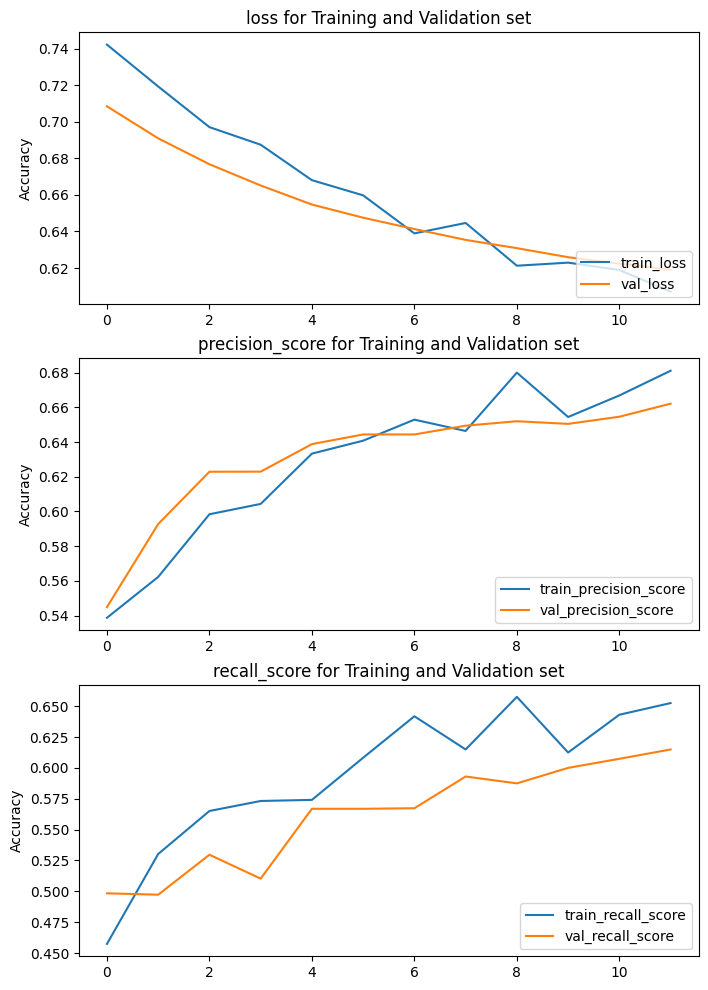

In [26]:
visualize(history)

No Overfit

In [29]:
y_train_pred = model_predict(model, ds_train_img)
y_valid_pred = model_predict(model, ds_valid_img)

accuracy_report(y_train, y_train_pred, dataset_name="Training")
accuracy_report(y_valid, y_valid_pred, dataset_name="Validation")

Accuracy Scores on Training Set
Confusion Matrix : [[466   223]]
                   [[237   453]]
Accuracy Score : 0.6664249456127629
** Precision Score : 0.6701183431952663 **
Recall Score : 0.6565217391304348
F1 Score : 0.6632503660322108
Accuracy Scores on Validation Set
Confusion Matrix : [[111   48]]
                   [[62   97]]
Accuracy Score : 0.6540880503144654
** Precision Score : 0.6689655172413793 **
Recall Score : 0.610062893081761
F1 Score : 0.6381578947368421


<u>Error Analysis</u>

Human Level Performance : 98% on accuracy

                 ^
                 |
                32%
                 |

Training Performance : 66% on accuracy

                 ^
                 |
                 1%
                 |

Development Performance : 65% on accuracy

<u>Note</u>

- Gap between Training-Human is larger than Training-Dev (bias) --> need better algorithm, i.e., more complex neural network, hyperparameter tuning

- *If gap between Training-Human is lower than Training-Dev (variance) --> more data, regularization*

<a name='4.2'></a>
### 4.2) Experiment 2 - Image only, Transfer Learning (MobileNet) : open last layer(s)

- Open top layer(s) for training
- May be more regularization if overfit, such as L1/L2, Dropout, Early Stopping

In [24]:
# explore base model
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    weights=None,
    # input_tensor=processing_input,
    pooling="avg",
)
print("Number of layers : {}".format(len(base_model.layers)))

Number of layers : 155


In [41]:
base_model.summary()

Model: "mobilenetv2_1.00_None"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_7[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                           

In [27]:
base_model.layers[134].name

'block_15_expand'

We will try 2 things
 - open last Conv2D Layer for training
 - open block 16 for training

<a name='4.2.1'></a>
- **4.2.1) Open last Conv2D Layer for training**

In [22]:
# load original model weight
path = latest_h5(r"model\v1_transfer_learning")

original_model = model_mobile_net_v1()
original_model.load_weights(path)

In [85]:
def model_mobile_net_v2_1():
    # create model v2
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2)
    ])
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet',
        # input_tensor=processing_input,
        pooling="avg",
    )
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
    
    # set trainable
    base_model.trainable = True
    
    # freeze layers
    fine_tune_at = 151  # 'Conv_1' layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False) # still keep non-trainable weight unchanged
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [101]:
model = model_mobile_net_v2_1()

# transfer weight in last dense layer
model.layers[-1].set_weights(original_model.layers[-1].get_weights())

In [102]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                           

In [106]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE/10) # lower learning rate
metrics = [keras.metrics.Precision(), keras.metrics.Recall()]

model.compile(loss=loss, metrics=metrics, optimizer=opt)
history = model.fit(ds_train_img, validation_data=ds_valid_img, epochs=10)

Epoch 1/10
44/44 [==============================] - 31s 636ms/step - loss: 0.6052 - precision: 0.6965 - recall: 0.6551 - val_loss: 0.6091 - val_precision: 0.6761 - val_recall: 0.6038
Epoch 2/10
44/44 [==============================] - 28s 647ms/step - loss: 0.5893 - precision: 0.6998 - recall: 0.6725 - val_loss: 0.6014 - val_precision: 0.6875 - val_recall: 0.6226
Epoch 3/10
44/44 [==============================] - 29s 651ms/step - loss: 0.5824 - precision: 0.7042 - recall: 0.6797 - val_loss: 0.5961 - val_precision: 0.6913 - val_recall: 0.6478
Epoch 4/10
44/44 [==============================] - 29s 655ms/step - loss: 0.5762 - precision: 0.7134 - recall: 0.6928 - val_loss: 0.5908 - val_precision: 0.7000 - val_recall: 0.6604
Epoch 5/10
44/44 [==============================] - 28s 649ms/step - loss: 0.5643 - precision: 0.7173 - recall: 0.6841 - val_loss: 0.5864 - val_precision: 0.7067 - val_recall: 0.6667
Epoch 6/10
44/44 [==============================] - 29s 661ms/step - loss: 0.5584 - p

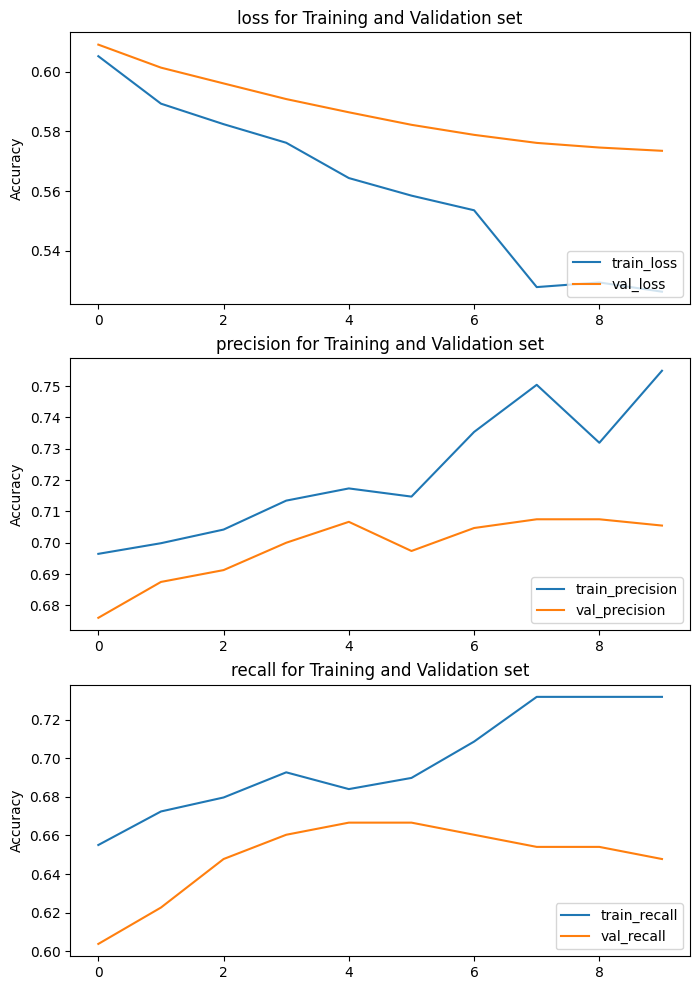

In [109]:
visualize(history)

Overfit after epoch 4 - may be add some dropout and early stopping (regarding option 2)

In [110]:
y_train_pred = model_predict(model, ds_train_img)
y_valid_pred = model_predict(model, ds_valid_img)

accuracy_report(y_train, y_train_pred, dataset_name="Training")
accuracy_report(y_valid, y_valid_pred, dataset_name="Validation")

10/10 [==============================] - 4s 428ms/step
Accuracy Scores on Training Set
Confusion Matrix : [[525   164]]
                   [[205   485]]
Accuracy Score : 0.7324147933284989
** Precision Score : 0.7473035439137135 **
Recall Score : 0.7028985507246377
F1 Score : 0.7244212098581032
Accuracy Scores on Validation Set
Confusion Matrix : [[116   43]]
                   [[56   103]]
Accuracy Score : 0.6886792452830188
** Precision Score : 0.7054794520547946 **
Recall Score : 0.6477987421383647
F1 Score : 0.6754098360655738


<a name='4.2.2'></a>
- **4.2.2) Open last Conv2D Layer for training (Dropout, Early Stopping, Lower learning rate)**

In [23]:
def model_mobile_net_v2_2():
    # create model v2
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2)
    ])
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet',
        # input_tensor=processing_input,
        pooling="avg",
    )
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
    
    # set trainable
    base_model.trainable = True
    
    # freeze layers
    fine_tune_at = 151  # 'Conv_1' layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False) # still keep non-trainable weight unchanged
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [24]:
model = model_mobile_net_v2_2()

model.layers[-1].set_weights(original_model.layers[-1].get_weights())

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                           

In [26]:
# lr decay callback
def schedule(epoch, lr):
    initial_lr = INITIAL_LEARNING_RATE/10
    return initial_lr * tf.math.pow(0.5, tf.math.floor(epoch/3))

lr = tf.keras.callbacks.LearningRateScheduler(
    schedule, verbose=0
)

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', min_delta=.01, patience=3, verbose=1,
    mode='max', restore_best_weights=True, start_from_epoch=3
)

# loss
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam() # lower learning rate
metrics = [keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]

model.compile(loss=loss, metrics=metrics, optimizer=opt)
history = model.fit(ds_train_img, validation_data=ds_valid_img, epochs=20, callbacks=[lr, early_stopping])

Epoch 1/20
44/44 [==============================] - 33s 660ms/step - loss: 0.6382 - precision: 0.6619 - recall: 0.6101 - val_loss: 0.6086 - val_precision: 0.6783 - val_recall: 0.6101 - lr: 1.0000e-05
Epoch 2/20
44/44 [==============================] - 28s 641ms/step - loss: 0.6341 - precision: 0.6706 - recall: 0.6522 - val_loss: 0.6025 - val_precision: 0.6897 - val_recall: 0.6289 - lr: 1.0000e-05
Epoch 3/20
44/44 [==============================] - 29s 652ms/step - loss: 0.6109 - precision: 0.6889 - recall: 0.6580 - val_loss: 0.5964 - val_precision: 0.6980 - val_recall: 0.6541 - lr: 1.0000e-05
Epoch 4/20
44/44 [==============================] - 29s 653ms/step - loss: 0.6029 - precision: 0.6891 - recall: 0.6681 - val_loss: 0.5938 - val_precision: 0.6980 - val_recall: 0.6541 - lr: 5.0000e-06
Epoch 5/20
44/44 [==============================] - 28s 649ms/step - loss: 0.5947 - precision: 0.7098 - recall: 0.6594 - val_loss: 0.5916 - val_precision: 0.6986 - val_recall: 0.6415 - lr: 5.0000e-06


In [37]:
model_h5_filename = "model_weight_{}.h5".format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
save_path = os.path.join("model", "v2_2_transfer_learning", model_h5_filename)

if not os.path.exists(os.path.dirname(save_path)):
    # make dir if not exists
    os.makedirs(os.path.dirname(save_path))

model.save(save_path)
print("model saved at : {}".format(save_path))

model saved at : model\v2_2_transfer_learning\model_weight_2023_02_21_21_10_43.h5


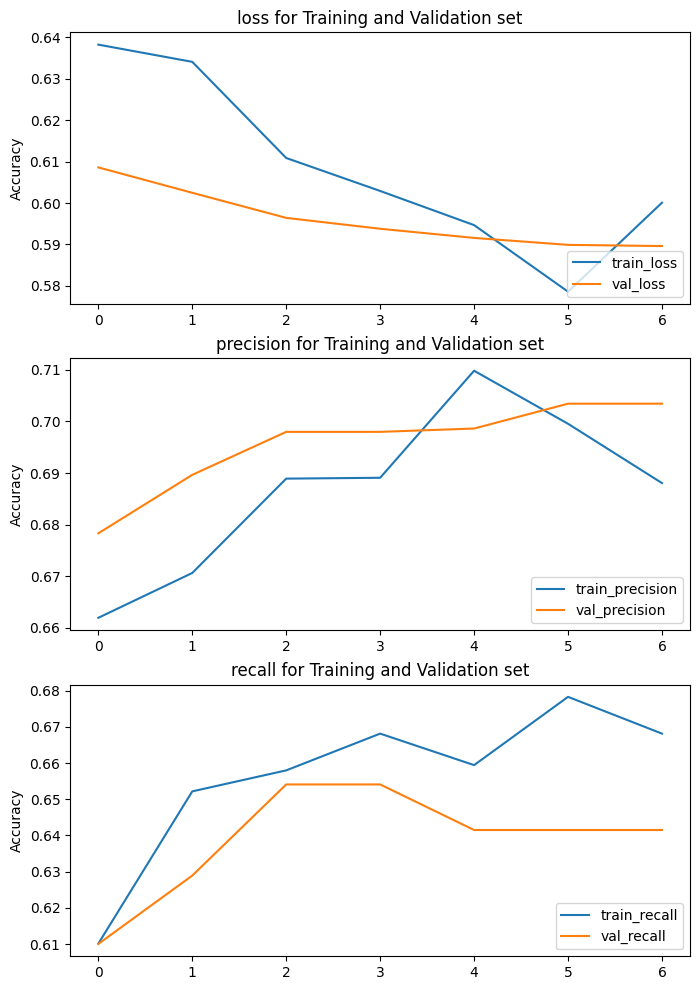

In [36]:
visualize(history)

In [31]:
y_train_pred = model_predict(model, ds_train_img)
y_valid_pred = model_predict(model, ds_valid_img)

accuracy_report(y_train, y_train_pred, dataset_name="Training")
accuracy_report(y_valid, y_valid_pred, dataset_name="Validation")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
10/10 [==============================] - 5s 459ms/step
Accuracy Scores on Training Set
Confusion Matrix : [[501   188]]
                   [[233   457]]
Accuracy Score : 0.6947063089195069
** Precision Score : 0.7085271317829457 **
Recall Score : 0.6623188405797101
F1 Score : 0.6846441947565542
Accuracy Scores on Validation Set
Confusion Matrix : [[114   45]]
                   [[55   104]]
Accuracy Score : 0.6855345911949685
** Precision Score : 0.697986577181208 **
Recall Score : 0.6540880503144654
F1 Score : 0.6753246753246753


<a name='4.2.3'></a>
**4.2.3) Open last 2 blocks and Conv2D Layer for training (Dropout, Early Stopping, Lower learning rate)**

In [37]:
path = latest_h5(r"model\v2_2_transfer_learning")

# load original model
original_v2_model = tf.keras.models.load_model(path)

In [38]:
def model_mobile_net_v2_3():
    # create model v2
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2)
    ])
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights=None, # using pre-load weight from previous model
        # input_tensor=processing_input,
        pooling="avg",
    )
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
    
    # set trainable
    base_model.trainable = True
    
    # freeze previous layers
    fine_tune_at = 134  # 'block_15_expand' layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False) # still keep non-trainable weight unchanged
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [40]:
model = model_mobile_net_v2_3()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                             

In [44]:
# transfer weight
model.layers[-3].set_weights(original_v2_model.layers[-3].get_weights()) # mobilenet weight
model.layers[-1].set_weights(original_v2_model.layers[-1].get_weights()) # dense layer weight

In [46]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', min_delta=.01, patience=3, verbose=1,
    mode='max', restore_best_weights=True, # start_from_epoch=3
)

# loss
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE/10) # lower learning rate
metrics = [keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]

model.compile(loss=loss, metrics=metrics, optimizer=opt)
history = model.fit(ds_train_img, validation_data=ds_valid_img, epochs=20, callbacks=[early_stopping])

Epoch 1/20
44/44 [==============================] - 38s 738ms/step - loss: 0.5911 - precision: 0.7011 - recall: 0.6696 - val_loss: 0.5872 - val_precision: 0.6845 - val_recall: 0.7233
Epoch 2/20
44/44 [==============================] - 31s 708ms/step - loss: 0.5827 - precision: 0.7107 - recall: 0.7014 - val_loss: 0.5776 - val_precision: 0.6970 - val_recall: 0.7233
Epoch 3/20
44/44 [==============================] - 32s 726ms/step - loss: 0.5474 - precision: 0.7396 - recall: 0.7203 - val_loss: 0.5770 - val_precision: 0.6685 - val_recall: 0.7484
Epoch 4/20
44/44 [==============================] - 32s 719ms/step - loss: 0.5416 - precision: 0.7300 - recall: 0.7130 - val_loss: 0.5717 - val_precision: 0.6780 - val_recall: 0.7547
Epoch 5/20
44/44 [==============================] - 31s 708ms/step - loss: 0.5323 - precision: 0.7459 - recall: 0.7188 - val_loss: 0.5661 - val_precision: 0.6879 - val_recall: 0.7484
Epoch 5: early stopping


In [47]:
model_h5_filename = "model_weight_{}.h5".format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
save_path = os.path.join("model", "v2_3_transfer_learning", model_h5_filename)

if not os.path.exists(os.path.dirname(save_path)):
    # make dir if not exists
    os.makedirs(os.path.dirname(save_path))

model.save(save_path)
print("model saved at : {}".format(save_path))

model saved at : model\v2_3_transfer_learning\model_weight_2023_02_22_08_28_12.h5


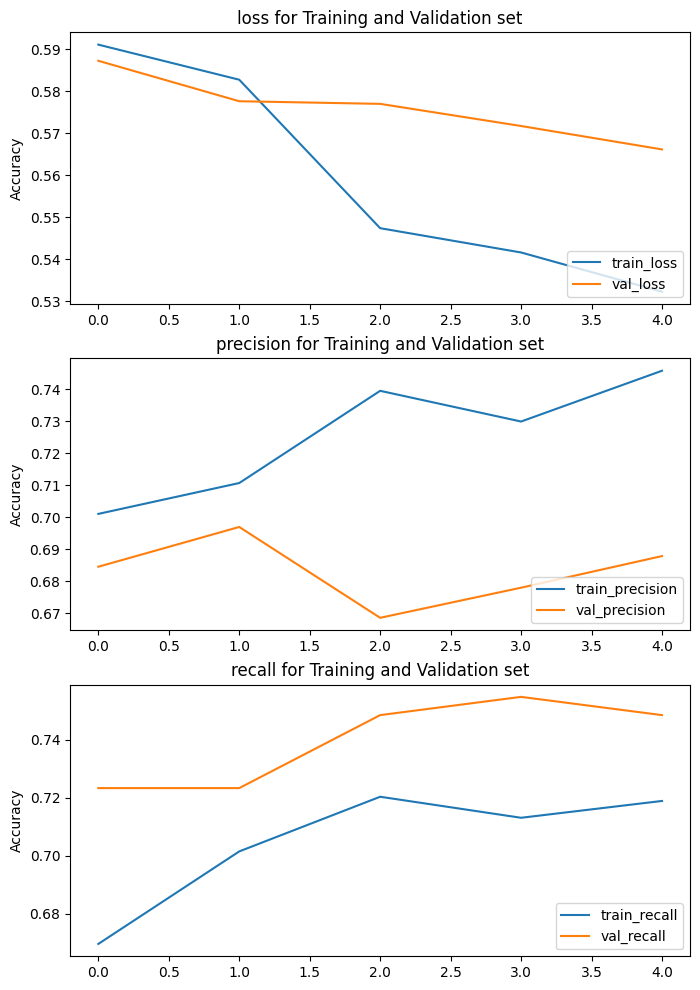

In [48]:
visualize(history)

In [49]:
y_train_pred = model_predict(model, ds_train_img)
y_valid_pred = model_predict(model, ds_valid_img)

accuracy_report(y_train, y_train_pred, dataset_name="Training")
accuracy_report(y_valid, y_valid_pred, dataset_name="Validation")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
10/10 [==============================] - 5s 441ms/step
Accuracy Scores on Training Set
Confusion Matrix : [[478   211]]
                   [[188   502]]
Accuracy Score : 0.7106598984771574
** Precision Score : 0.7040673211781207 **
Recall Score : 0.7275362318840579
F1 Score : 0.7156094084105488
Accuracy Scores on Validation Set
Confusion Matrix : [[109   50]]
                   [[44   115]]
Accuracy Score : 0.7044025157232704
** Precision Score : 0.696969696969697 **
Recall Score : 0.7232704402515723
F1 Score : 0.7098765432098766


<u>Error Analysis</u>

Human Level Performance : 98% on accuracy

                 ^
                 |
                27%
                 |

Training Performance : 71% on accuracy

                 ^
                 |
                 1%
                 |

Development Performance : 70% on accuracy

Training accuracy is improving from 66% to 71% (65% to 70% for Development set), which is quite nice. However, we still have a huge improvement gap between Training performance and HLP performance. But what can we do in terms of model improvement since we've done almost everyhings on promotion images.

May be it's time to do the Error Analysis on incorrectly labeled data.

<a name='4.3'></a>
### 4.3) Error Analysis (on misclassified examples)

In [30]:
path = latest_h5(r"model\v2_3_transfer_learning")

current_model = tf.keras.models.load_model(path)

In [43]:
y_valid_pred = model_predict(current_model, ds_valid_img)

error_analysis_data = X_valid.copy()
error_analysis_data['y_true'] = y_valid
error_analysis_data['y_pred'] = y_valid_pred

incorrect_examples = error_analysis_data[error_analysis_data.y_true != error_analysis_data.y_pred]

print("Incorrectly classified example : {}".format(incorrect_examples.shape[0]))

10/10 [==============================] - 4s 397ms/step
Incorrectly classified example : 94


In [45]:
analysis_outdir = os.path.join("report", "analysis")
os.makedirs(analysis_outdir)

incorrect_examples.to_csv(os.path.join(analysis_outdir, "error_analysis_img_transfer.csv"))

Conduct error analysis manually ....

In [2]:
# analyzed error analysis file
analysis_dir = os.path.join("report", "analysis")
path = os.path.join(os.getcwd(), analysis_dir, "error analysis.xlsx") # C:\Users\11413929\repos\promotion_classifier\report\analysis\error analysis.xlsx

analysis_file = pd.read_excel(path)

# fill NaN
incorrect_type = analysis_file.columns[~analysis_file.columns.isin(['PromotionId', 'description', 'y_true', 'y_pred'])].tolist()
analysis_file.loc[:, incorrect_type] = analysis_file[incorrect_type].fillna(0).astype(int)

In [6]:
analysis_file.head()

,PromotionId,description,y_true,y_pred,miss_labeled,txt_description_nulll,txt_discount_description,txt_alcoholic,txt_no_promotion,txt_loyalty_details,img_screen_capture,img_discount_description,img_alcoholic,img_no_promotion,img_loyalty_details,img_graphic,img_include_text
0,1NWLD4Kb51PCWV11l5P2R47WAFBa5d,มีบริการส่งฟรี​ (ตามระยะทาง​ ที่ร้านกำหนด​)​,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1NWLB5UIwyVyFzhqqjLd5uvpgUyRdV,ข้าวผัดซีฟู้ด อร่อยเหาะ อร่อยที่สุด\n\n\n,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1NWLB4qGBxYUivsSZItVx8WfE699Kx,ซื้อ 10 ไม้ ฟรี 1 ไม้\n\n\n\n แบบ 5 บาท 10 ไม้...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1NWLAvgSKGWWZhILvYEZFMqVOvguRO,Hmmmmmmm,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1NWLCtqDSc5WVXRuQEWkRFzPbDkfWm,รวมใหญ่199฿,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [7]:
incorrect_type

['miss_labeled',
 'txt_description_nulll',
 'txt_discount_description',
 'txt_alcoholic',
 'txt_no_promotion',
 'txt_loyalty_details',
 'img_screen_capture',
 'img_discount_description',
 'img_alcoholic',
 'img_no_promotion',
 'img_loyalty_details',
 'img_graphic',
 'img_include_text']

In [76]:
# error percentage by each incorrect type
analysis_file[incorrect_type].sum()/analysis_file.shape[0]

miss_labeled                0.053191
txt_description_nulll       0.159574
txt_discount_description    0.457447
txt_alcoholic               0.031915
txt_no_promotion            0.244681
txt_loyalty_details         0.010638
img_screen_capture          0.031915
img_discount_description    0.180851
img_alcoholic               0.042553
img_no_promotion            0.191489
img_loyalty_details         0.031915
img_graphic                 0.446809
img_include_text            0.500000
dtype: float64

In [78]:
analysis_file[analysis_file.txt_discount_description == 1][['y_true', 'y_pred']].drop_duplicates()

,y_true,y_pred
2,0,1


In [79]:
analysis_file[analysis_file.txt_no_promotion == 1][['y_true', 'y_pred']].drop_duplicates()

,y_true,y_pred
0,1,0


In [81]:
count_ = analysis_file[(analysis_file.txt_discount_description == 1) | (analysis_file.txt_no_promotion == 1)].shape[0]

print("Total percentage of misclassified samples with identificable promotion description : {}%".format(
    round(100 * count_ / analysis_file.shape[0], 2)))

Total percentage of misclassified samples with identificable promotion description: 70.21%


In [88]:
count_ = analysis_file[(analysis_file.txt_loyalty_details == 1) | (analysis_file.img_loyalty_details == 1)].shape[0]

print("Total percentage of misclassified samples in Loyalty case : {}%".format(
    round(100 * count_ / analysis_file.shape[0], 2)))

Total percentage of misclassified samples in Loyalty case : 3.19%


In [89]:
count_ = analysis_file[(analysis_file.txt_alcoholic == 1) | (analysis_file.img_alcoholic == 1)].shape[0]

print("Total percentage of misclassified samples in Alcoholic case : {}%".format(
    round(100 * count_ / analysis_file.shape[0], 2)))

Total percentage of misclassified samples in Alcoholic case : 4.26%


In [90]:
count_ = analysis_file[analysis_file.img_screen_capture == 1].shape[0]

print("Total percentage of misclassified samples in Screen Shot case : {}%".format(
    round(100 * count_ / analysis_file.shape[0], 2)))

Total percentage of misclassified samples in Screen Shot case : 3.19%


In [17]:
count_ = analysis_file[((analysis_file.txt_discount_description != 1) & (analysis_file.txt_no_promotion != 1)) & 
                       (analysis_file.img_include_text == 1)].shape[0]

print("Total percentage of misclassified samples with only text image : {}%".format(
    round(100 * count_ / analysis_file.shape[0], 2)))

Total percentage of misclassified samples with only text image : 20.21%


In [10]:
df = analysis_file[((analysis_file.txt_discount_description != 1) & (analysis_file.txt_no_promotion != 1)) & 
                   (analysis_file.img_include_text == 1)]

print("Percentage of misclassified samples with only text image provided group by each misclassified type")
df.groupby(['y_true', 'y_pred']).size()/analysis_file.shape[0]

Percentage of misclassified samples with only text image provided group by each misclassified type


y_true  y_pred
0       1         0.063830
1       0         0.138298
dtype: float64

In [20]:
df = analysis_file[((analysis_file.txt_discount_description != 1) & (analysis_file.txt_no_promotion != 1))]

incorrect_type_consider = [
    'img_discount_description',
    'img_alcoholic',
    'img_no_promotion',
    'img_loyalty_details'
]

for incorrect_type in incorrect_type_consider:
    count_ = df[(df[incorrect_type] == 1) & (df.img_include_text == 1)].shape[0]
    print("Total percentage of misclassified samples with incorrect type {} : {}%".format(
        incorrect_type, round(100 * count_ / analysis_file.shape[0], 2)))

Total percentage of misclassified samples with incorrect type img_discount_description : 5.32%
Total percentage of misclassified samples with incorrect type img_alcoholic : 4.26%
Total percentage of misclassified samples with incorrect type img_no_promotion : 7.45%
Total percentage of misclassified samples with incorrect type img_loyalty_details : 3.19%


In [24]:
count_ = analysis_file[(analysis_file.txt_description_nulll == 1)].shape[0]

print("Total percentage of misclassified samples with NaN description : {}%".format(
    round(100 * count_ / analysis_file.shape[0], 2)))
analysis_file.groupby(['y_true', 'y_pred', 'txt_description_nulll']).size()/analysis_file.shape[0]

Total percentage of misclassified samples with NaN description : 15.96%


y_true  y_pred  txt_description_nulll
0       1       0                        0.489362
                1                        0.042553
1       0       0                        0.351064
                1                        0.117021
dtype: float64

In [14]:
analysis_file.groupby(['y_true', 'y_pred', 'img_graphic']).size()/analysis_file.shape[0]

y_true  y_pred  img_graphic
0       1       0              0.329787
                1              0.202128
1       0       0              0.223404
                1              0.244681
dtype: float64

<u>Key points noted here</u> :
 - We have miss labeled data, but only 5% of misclassified samples <code>--></code> data correction **may not** help that much
 - We have 70% of total misclassified samples with identificable promotion description <code>--></code> considering text information **would be** useful
    - 45% of misclassified samples (y_true=0, y_pred=1)
    - 25% of misclassified samples (y_true=1, y_pred=0)
 - We don't have much data in Screen Capture, Loyalty Details, and Alcoholic case <code>--></code> may be consider on collecting more data on these cases
    - 3.2% of misclassified samples are Loyalty case
    - 4.3% of misclassified samples are Alcoholic case
    - 3.2% of misclassified samples are Screenshot case
 - We have 20% of total misclassified samples with only text picture provided (no promotion description)
    - 5.2% of misclassified samples contains text info with promotion
    - 7.5% of misclassified samples contains text info without promotion
    - 4.3% of misclassified samples contains text info with alcoholic promotion
    - 3.2% of misclassified samples contains text info with loyalty promotion\
   <code>--></code> Meaning that by using text extraction, we could **top-up** the model performance by around 13% (without considering Alcoholic and Loyalty)
 - No insights from img_graphic and txt_description_null

<a name='4.4'></a>
### 4.4) Experiment 3 - including text data for classification

<a name='4.4.1'></a>
- **4.4.1) Data Exploration (Text) and Preprocessing**

In [55]:
df_train.head()

,description,bad
PromotionId,,
1NWLCQqhS3TUHuBR400eJ3224ugi9E,กุ้งเผา 2 ไซ 550 บาท/กิโล 650 บาท/กิโล\n\n\n\n,1.0
1NWLCpx0i30wIWX645i9MQGQhY8dXB,ชิวๆง่ายๆใจกลางเมือง,1.0
1NWLC9my0fqwRZXUWbvGgPP4dLNJc2,NaN,1.0
1NWLCRye757xKLMMAuwXV6MbdbeOQ4,NaN,1.0
1NWLBLOuCSGLRhRnPiThoBq8nmWiSe,NaN,0.0


In [76]:
df_train.isnull().sum()

description    375
bad              0
dtype: int64

In [22]:
df_train[df_train.description.notna()].shape[0]

1004

In [33]:
f_thai_match = lambda x: bool(re.search("[\u0E00-\u0E7F]", x))
f_eng_match = lambda x: bool(re.search("[A-Za-z]", x))

description_thai_only = df_train[df_train.description.fillna("").apply(f_thai_match) & 
                                 ~df_train.description.fillna("").apply(f_eng_match)]

print("Numbers of Thai-only description : {}".format(description_thai_only.shape[0]))
description_thai_only.head()

Numbers of Thai-only description : 638


,description,bad
PromotionId,,
1NWLCQqhS3TUHuBR400eJ3224ugi9E,กุ้งเผา 2 ไซ 550 บาท/กิโล 650 บาท/กิโล\n\n\n\n,1.0
1NWLCpx0i30wIWX645i9MQGQhY8dXB,ชิวๆง่ายๆใจกลางเมือง,1.0
1NWLCLqE7CXVZkdp0tSQqLSoPxJ7wm,รับฟรี ชาเขียวเย็น \n\n\n\nเพียงแอดไลน์ และ ไล...,0.0
1NWLCF4TABS3vUQUvqTD88pYL2BVOE,ทุกวันศุกร์ มีบุฟเฟ่ต์ 100 บาท\n\n\n\nอิ่มไม่อ...,1.0
1NWLB6RbEedBW3082YnXTEktZ2NVgA,ขนมเบื้อง ครีม แป้งชาโคล,1.0


In [34]:
description_eng_only = df_train[~df_train.description.fillna("").apply(f_thai_match) & 
                                df_train.description.fillna("").apply(f_eng_match)]

print("Numbers of Eng-only description : {}".format(description_eng_only.shape[0]))
description_eng_only.head()

Numbers of Eng-only description : 43


,description,bad
PromotionId,,
1NWLBmWPy5cMi4AUNcApYIdwv0ut0n,Bar B Q 🍺Budweiser,1.0
1NWLBd15n46P642Gb0qnVmOgfn2Ccq,Must try!,1.0
1NWLAqHQnbJ6gJH8PNIV55BqYxlIq2,Buy 2 get 1 free,0.0
1NWLD4dhrGR0O0gyi99LVZb1LLkDT1,Dhdggd,1.0
1NWLCwhVMu3zA7YqBYWubniT0ksDjF,Promotion Peach and Tea,0.0


In [36]:
description_thai_eng = df_train[df_train.description.fillna("").apply(f_thai_match) & 
                                 df_train.description.fillna("").apply(f_eng_match)]

print("Numbers of Thai-Eng description : {}".format(description_thai_eng.shape[0]))
description_thai_eng.head()

Numbers of Thai-Eng description : 321


,description,bad
PromotionId,,
1NWLBnTCQQsSMfuDxecunvVk0ZDIFz,วันนี้ - 30 ก.ย. ทางร้านจัดโปรโมชั่นสุดพิเศษ ล...,0.0
1NWLB1UXIPcHKJ1I2kAo77pTVV6Y6n,11-12-13 สิงหาคม 61 พิเศษสุดสำหรับวันแม่ กับชุ...,0.0
1NWLBe9AaZ45bsXBZZYAB0mPa6LBRk,🌋 ฟรี! น่องไก่กรอบ 1 กระปุก มูลค่า 65 บาท\n\n\...,0.0
1NWL9vRBSGEjIO72PCXcGe6eKMd3oT,พบกับเมนูใหม่! เป็ดปักกิ่ง Four Season ในราคาพ...,0.0
1NWLBBhmZWJWvSYCvNpdvPqifTJ8oV,ลดราคากันไปเลย20บาทคุ้มมากที่Greenchef,0.0


<u>Insights that we've found in promotion description</u>

In [80]:
def search_promotion_id(id_):
    mapper = {
        "Training": df_train,
        "Validation": df_valid,
        "Testing": df_test
    }
    
    for key, df in mapper.items():
        if id_ in df.index:
            print("Your provided promotion ID is in {} set".format(key))
            break
            
search_promotion_id(id_='1NWLBRBOnyz9EmnUr8Ssw15nwaSFQb')

Your provided promotion ID is in Training set


In [42]:
print("We have non-alphabet character (e.g. emoji, special characters) like this")
df_train.loc['1NWLC7TPLPhT2aBMjlfOdR2G7km72w', 'description']

We have non-alphabet character (e.g. emoji, special characters) like this


'หาของฝากจากเชียงใหม่ให้คนที่เรารัก ... 🐷หมูยอใบตอง อร่อยๆ จากบ้านนินตรา ซิคะ.  สัมผัสเนื้อหมูแบบเต็มคำ\n\n\n\n\n\nพิเศษ!!!  (เฉพาะ วันที่1-2 ก.ย.นี้เท่านั้นจ้ะ)\n\n\nซื้อ 6 แถม 1 \n\n\n\n\n\nติดต่อ\n\n\nLine@ : https://line.me/R/ti/p/%40mcg6289w'

In [43]:
print("We also have embeded http link (like the previous one and this one)")
df_train.loc['1NWLAvnEIul1urJbSwSmo2gEJEJQUx', 'description']

We also have embeded http link (like the previous one and this one)


'1. กด Like เพจ https://www.facebook.com/pg/SanaeBeachClub/\n\n\n\n2. กด Share เพจ https://www.facebook.com/pg/SanaeBeachClub/ (ตั้งเป็นสาธารณะ)\n\n\n\n3. โชว์ Like & Share กับพนักงาน พร้อมรับ CODE ส่วนลด อาหาร และ เครืองดื่ม 20%\n\n\n\n\n\n\n\nสอบถามเพิ่มเติมได้ที่ 032 - 900971'

In [57]:
print("We also able to detect some pattern for discount : \d+%")
df_test.loc['1NWLD3dp7tdq34WkgzQGLiPQM7dFC5', 'description']

We also able to detect some pattern for discount : \d+%


'ทะเลทะลัก!! สุดยอดบุฟเฟ่ต์ทะเล ที่คุณไม่ควรพลาด\n\n\n\n\n\nลดสูงสุด 60% จากราคา 1900 บาทสุทธิ! จองเลย\n\n\nวันศุกร์และวันเสาร์ ตั้งแต่เวลา 18.00-22.00 น.\n\n\nราคานี้รวมชา กาแฟร้อนไม่อั้น น้ำอัดลม\n\n\nสมาชิกแอคคอร์พลัสรับส่วนลดออนท็อปอีก 10%'

In [59]:
print("We also have multiple line separation for each sentence")
df_test.loc['1NWLA7pDgz3QEyKvMswAWtXVzcI9Ra', 'description']

We also have multiple line separation for each sentence


'โปรมื้อค่ำ มี 2 แบบให้เลือก 17:00-23:00\n\n\nเมื่อสั่งซุปต้นตำรับ ราคา800บาท...\n\n\n1)รับฟรี! ชุดลูกชิ้นเนื้อรวม/หมูรวม ลูกชิ้นลาวารวม และชุดผักรวม มูลค่า320.-\n\n\n2)รับส่วนลด50% เมื่อสั่งเนื้อ Himawari ทุกประเภท'

In [62]:
print("Some word normalization may be useful (e.g. cocktail --> ค๊อกเทล)")
df_valid.loc['1NWLAvtJV2wVlBV9EOtglj8nvYJOGr', 'description']

Some word normalization may be useful (e.g. cocktail --> ค๊อกเทล)


'ซื้อ1แก้ว แถม1แก้ว ฟรี!!!!!\n\n\n\nตั้งแต่เวลา 17.00 - 19.00\n\n\n\nHappy Hours for every Afternoon Hour!!!\n\n\n\n* TIMINGS : 17.00 - 19.00\n\n\n\n* OFFER: Inclusive of beer, wine and our signature Cocktails with one get one free!!!\n\n\n\n\n\n\n\nReservation please call : +66 76608885\n\n\n\n'

In [66]:
# สค / ส.ค. --> สิงหาคม
df_train.loc['1NWLBfbj8jCoNLikUT9qLoNmSqmxiK', 'description']

'โปรโมชั่นเปิดร้าน มา 5 จ่าย 4 \n\n\n\nหัวละ 129.- รวมน้ำรีฟิลแล้ว\n\n\n\nอิ่ม ไม่อั้น ไม่จำกัดเวลา\n\n\n\nถึง 25 สค 61 นี้เท่านั้น \n\n\n\n**โปรใหม่ติดตามได้ในเพจ @จอดแล้วจุ่ม'

<u>Text Preprocessing Steps</u>
- lower casing (<code>.lower()</code>)
- remove special characters (e.g. !, %)
- replace white space for **same** language
- remove noisy characters (e.g. emoji, special characters)
- remove digits (e.g. 0-9)
- remove stopwords
- text normalization (e.g. โปรฯ = โปรโมชั่น, ก.ย. = กันยายน)
- addressing out-of-vocabulary words (e.g. convert some important Eng words to Thai)
- english words require stemming, lemmatization, etc.
- sentence separation
- word tokenization

In [20]:
path = os.path.join('assets', 'LTW2V_v1.0-window15.bin')

word2vec_model = KeyedVectors.load_word2vec_format(path, binary=True, unicode_errors='ignore')

In [168]:
# domain words (since we don't have enough data)
domain_words_th = {
    "alcohol": [
        "อาซาฮี",
        "ไฮเนเก้น",
        "ค๊อกเทล",
        "บัดไวเซอร์",
        "โฮการ์เด้น"
    ],
    # "loyalty": [
    #     "สะสม",
    #     "แต้ม",
    #     "สแตมป์"
    # ],
    # "screen_capture": [
    #     "อินสตาแกรม",
    #     "เฟดบุ๊ค",
    #     "เฟสบุ๊ค",
    #     "เฟซบุ๊ค"
    # ],
    "promotion": [
        "โปร"
    ]
}

domain_words_eng = {
    "screen_capture": [
        "facebook",
        "fb",
        "instagram",
        "ig"
    ],
    "alcoholic": [
        "asahi",
        "chang",
        'budweiser',
        # 'beer',
        # 'bar',
        # 'champagne',
        # 'cocktail',
        'heogaarden',
        'heineken',
        # 'tabasco',
        # 'vodka',
        # 'wine'
    ],
    "promotion": [
        "promo"
    ]
}

# preprocess utils
set_stopword_eng = set(eng_stopwords.words('english'))
set_stopword_thai = set(thai_stopwords())
stopwords = set_stopword_thai.union(set_stopword_eng)

valid_words_eng = set(map(lambda x: x.lower(), eng_words.words()))

domain_words_eng = list(itertools.chain.from_iterable(list(domain_words_eng.values())))
domain_words_th = list(itertools.chain.from_iterable(list(domain_words_th.values())))

lemmatizer = WordNetLemmatizer()

In [195]:
# functions
def get_stopwords():
    set_stopword_eng = set(eng_stopwords.words('english'))
    set_stopword_thai = set(thai_stopwords())
    stopwords = set_stopword_thai.union(set_stopword_eng)
    
    return stopwords

def normalize_txt(df):
    def get_monthname(i):
        month_tuple = ("มกราคม", "กุมภาพันธ์", "มีนาคม", "เมษายน", "พฤษภาคม", "มิถุนายน",
                       "กรกฎาคม", "สิงหาคม", "กันยายน", "ตุลาคม", "พฤษจิกายน", "ธันวาคม")
        if i not in range(len(month_tuple)):
            raise IndexError(f"Month index {i} out of range")
        else:
            return month_tuple[i]

    def return_pattern(i):
        i_str = "{}".format(i)

        if len(i_str) == 1:
            return '0?{}'.format(i)
        else:
            return i
    
    df_copy = df.copy()
    
    # normalize month
    mapper_mth_expand = {
        r"(\d{0,2}\s?)(ม\.?ค\.?|มกรา(?!(คม)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 มกราคม \3",
        r"(\d{0,2}\s?)(ก\.?พ\.?|กุมภา(?!(พันธ์)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 กุมภาพันธ์ \3",
        r"(\d{0,2}\s?)(มี\.?ค\.?|มีนา(?!(คม)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 มีนาคม \3",
        r"(\d{0,2}\s?)(เม\.?ย\.?|เมษา(?!(ยน)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 เมษายน \3",
        r"(\d{0,2}\s?)(พ\.?ค\.?|พฤษภา(?!(คม)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 พฤษภาคม \3",
        r"(\d{0,2}\s?)(มิ\.?ย\.?|มิถุนา(?!(ยน)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 มิถุนายน \3",
        r"(\d{0,2}\s?)(ก\.?ค\.?|กฤกฎา(?!(คม)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 กรกฎาคม \3",
        r"(\d{0,2}\s?)(ส\.?ค\.?|สิงหา(?!(คม)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 สิงหาคม \3",
        r"(\d{0,2}\s?)(ก\.?ย\.?|กันยา(?!(ยน)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 กันยายน \3",
        r"(\d{0,2}\s?)(ต\.?ค\.?|ตุลา(?!(คม)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 ตุลาคม \3",
        r"(\d{0,2}\s?)(พ\.?ย\.?|พฤษจิกา(?!(ยน)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 พฤษจิกายน \3",
        r"(\d{0,2}\s?)(ธ\.?ค\.?|ธันวา(?!(คม)))(?![a-zA-Z\u0E00-\u0E7F])": r"\1 ธันวาคม \3"
    }
    mapper_mth_date = {
        r"(\d{1,2})/(%s)/(\d{1,4})" % return_pattern(i+1) : r"\1 %s \3" % get_monthname(i) \
        for i in range(12)
    }
    
    df_copy['description'] = df_copy.description.replace(mapper_mth_expand, regex=True)
    df_copy['description'] = df_copy.description.replace(mapper_mth_date, regex=True)
    
    # normalize baht
    df_copy['description'] = df_copy.description.str.replace("฿", "บาท", regex=False)
    df_copy['description'] = df_copy.description.str.replace("(\d+)\s?.-", "\1 บาท", regex=True)
    
    # normalize percent
    df_copy['description'] = df_copy.description.str.replace(r"(\d{1,2})\s?%", r"\1 เปอร์เซ็นต์", regex=True)
    
    # normalize promotion
    df_copy['description'] = df_copy.description.str.replace("โปรฯ", "โปรโมชั่น", regex=False)
    
    return df_copy

def clean_txt(df):
    df_copy = df.copy()
    
    # remove https
    df_copy['description'] = df_copy.description.str.replace('http\S+|www.\S+', '', regex=True)
    # remove newlines
    df_copy['description'] = df_copy.description.str.replace(r'(\n){2,}', '\n', regex=True) # replace multiple newlines
    df_copy['description'] = df_copy.description.str.replace(r'\n', ' ', regex=True) # replace newlines with whitespace
    # remove whitespace
    df_copy['description'] = df_copy.description.str.replace("([\u0E00-\u0E7F])\s([\u0E00-\u0E7F])", r"\1\2", regex=True)
    # remove special characters
    df_copy['description'] = df_copy.description.str.replace("[^\u0E00-\u0E7Fa-zA-Z\s]", "", regex=True)
    # remove duplicate word : น๊าาาา
    df_copy['description'] = df_copy.description.str.replace(r'([\u0E00-\u0E7Fa-zA-Z])\1{2,}', r'\1', regex=True)
    # lower()
    df_copy['description'] = df_copy.description.str.lower()
    
    return df_copy

def tokenize_th_word(df, custom_th_words: Optional[Set] = None):
    df_copy = df.copy()
    
    if custom_th_words:
        custom_dict = set(thai_words())
        custom_dict = custom_dict.union(custom_th_words)
        trie = dict_trie(dict_source=custom_dict)
        df_copy['description'] = df_copy.description.apply(word_tokenize, engine="newmm", custom_dict=trie,
                                                          keep_whitespace=False)
    else:
        df_copy['description'] = df_copy.description.apply(word_tokenize, engine="newmm",
                                                          keep_whitespace=False)
    
    # join tokenized wordback
    df_copy['description'] = df_copy.description.str.join(" ")
    
    return df_copy

def normalize_eng_word(df_eng, custom_eng_words: Optional[Set] = None):
    # valid word
    if custom_eng_words:
        # valid in domain
        df_eng['valid'] = df_eng.description.isin(valid_words_eng) | df_eng.description.isin(custom_eng_words)
    else:
        df_eng['valid'] = df_eng.description.isin(valid_words_eng)
    # lemmatization
    filter_lemma = df_eng.description.isin(valid_words_eng) 
    for pos in (wordnet.VERB, wordnet.NOUN):
        df_eng.loc[filter_lemma, 'description'] = \
            df_eng.loc[filter_lemma, 'description'].apply(lemmatizer.lemmatize, pos=pos)
    
    return df_eng

def word_replacement(df):
    map_eng = {
        "fb": "facebook",
        "ig": "instagram",
        "promo": "promotion",
        "asahi": 'beer',
        "chang": 'beer',
        'budweiser': 'beer',
        'heogaarden': 'beer',
        'heineken': 'beer',
    }
    map_th = {
        "อาซาฮี": "beer",
        "ไฮเนเก้น": "beer",
        "ค๊อกเทล": "cocktail",
        "บัดไวเซอร์": "beer",
        "โฮการ์เด้น": "beer"
    }
    
    df['description'] = df.description.replace(map_eng, regex=False)
    df['description'] = df.description.replace(map_th, regex=False)
    
    return df
    
def normalize_word(df, mode: str, stopwords : Optional[Set] = None, custom_eng_words : Optional[Set] = None):
    df_copy = df.copy()
    
    # normalize ๆ (e.g. ง่ายๆ = ง่าย ง่าย)
    df_copy['description'] = df_copy.description.str.replace(r"([\u0E00-\u0E45\u0E47-\u0E7F]+)\s?\u0E46", r'\1 \1', regex=True)
    # split word (and explode)
    df_copy['description'] = df_copy['description'].str.split(' ')
    df_copy = df_copy.explode('description')
    df_copy.reset_index(inplace=True) # avoiding dup promotion id
    # remove stopwords
    if stopwords:
        df_copy.loc[df_copy.description.isin(stopwords), 'description'] = ""
    # process eng word
    filter_eng = df_copy.description.str.match("^[a-z]+$")
    df_eng_prep = normalize_eng_word(df_copy[filter_eng], custom_eng_words)
    df_copy.loc[filter_eng, 'description'] = df_eng_prep['description']
    df_copy.loc[df_copy.index.isin(df_eng_prep[~df_eng_prep.valid].index), 'description'] = "" # filter out incorrect eng words
    # filter out word with length 1
    df_copy.loc[df_copy['description'].str.len() <= 1, 'description'] = ""
    # word replacement
    df_copy = word_replacement(df_copy)
    # join word back
    df_copy = df_copy.groupby(['PromotionId'], as_index=False).agg({'description': ' '.join})
    df_copy['description'] = df_copy.description.str.replace(r"\s+", " ", regex=True).str.rstrip() # escape join empth string

    return df_copy.loc[:, ['PromotionId', 'description']]
        
        
def preprocess_text(df, custom_th_words: Optional[Set] = None, custom_en_words: Optional[Set] = None, 
                    stopwords: Optional[Set] = None, mode: str = "Training"):
    if df.index.name != "PromotionId":
        raise Exception("excpect input df with index values from 'PromotionId' col")
    
    df_copy = df.copy()
    
    # Normalize TH text
    df_copy = normalize_txt(df_copy)
    # Clean text
    df_copy = clean_txt(df_copy)
    # Word tokenize
    df_copy = tokenize_th_word(df_copy, custom_th_words)
    # Normalize TH word :
    #   - Remove Stopwords
    #   - Stemming and Lemmatization
    #   etc.
    df_copy = normalize_word(df_copy, mode, stopwords, custom_en_words)
    # reset index
    df_copy = df_copy.set_index("PromotionId").reindex(df.index).reset_index()
    # join target back if mode = Training
    if mode == "Training":
        df_copy = pd.merge(df_copy, df[['bad']], left_on='PromotionId', right_on='PromotionId', how='left')
        df_copy = df_copy.loc[:, ['PromotionId', 'description', 'bad']]
    
    return df_copy

In [23]:
# processing train data
df_train_processed = preprocess_text(df_train, custom_th_words=domain_words_th, custom_en_words=domain_words_eng, 
                                     stopwords=stopwords)

# processing other data
df_valid_processed = preprocess_text(df_valid, custom_th_words=domain_words_th, custom_en_words=domain_words_eng, 
                                     stopwords=stopwords)
df_test_processed = preprocess_text(df_test, custom_th_words=domain_words_th, custom_en_words=domain_words_eng, 
                                     stopwords=stopwords)

C:\Users\11413929\AppData\Local\Temp\ipykernel_7084\4149683864.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng['valid'] = df_eng.description.isin(valid_words_eng) | df_eng.description.isin(custom_eng_words)
C:\Users\11413929\AppData\Local\Temp\ipykernel_7084\4149683864.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng['valid'] = df_eng.description.isin(valid_words_eng) | df_eng.description.isin(custom_eng_words)
C:\Users\11413929\AppData\Local\Temp\ipykernel_7084\4149683864.py:116: S

In [24]:
df_train_processed.head()

,PromotionId,description,bad
0,1NWLCQqhS3TUHuBR400eJ3224ugi9E,กุ้ง เผา ไซ บาท กิโล บาท กิโล,1.0
1,1NWLCpx0i30wIWX645i9MQGQhY8dXB,ชิว ชิว ใจ กลางเมือง,1.0
2,1NWLC9my0fqwRZXUWbvGgPP4dLNJc2,,1.0
3,1NWLCRye757xKLMMAuwXV6MbdbeOQ4,,1.0
4,1NWLBLOuCSGLRhRnPiThoBq8nmWiSe,,0.0


In [25]:
prep_row_count = df_train_processed.shape[0]
raw_row_count = df_train.shape[0]

assert prep_row_count == raw_row_count, "Rows in preprocessed df not match (raw={}, processed={})".format(
    raw_row_count,
    prep_row_count
)

<Axes: >

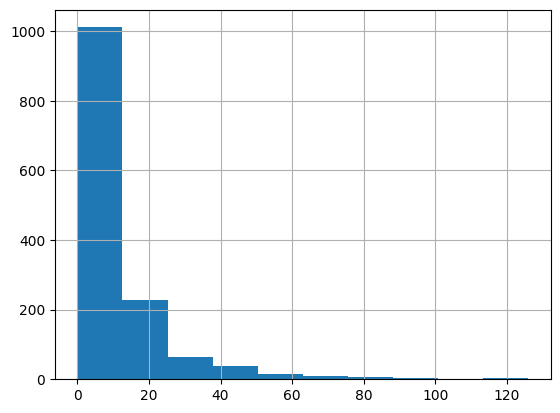

In [26]:
len_ = df_train_processed.description.str.split(" ").str.len()
filter_ = df_train_processed['description'].str.len() == 0
len_.loc[filter_] = 0

len_.hist()

In [30]:
len_.describe()

count    1379.000000
mean       10.227701
std        14.733789
min         0.000000
25%         0.000000
50%         5.000000
75%        13.000000
max       126.000000
Name: description, dtype: float64

In [74]:
len_.quantile(.95)

39.0

<a name='4.4.2'></a>
- **4.4.2) Add pre-trained Embedding layer (from Word2Vec model)**

*Look at gensim object*

In [31]:
word2vec_model.vectors.shape

(596005, 400)

In [34]:
word2vec_model.vectors[:5, :]

array([[-0.2562,  4.0615, -1.7027, ..., -2.2808, -1.6033,  0.4588],
       [ 2.2118,  1.9774,  1.4636, ...,  1.2064, -2.3075,  2.5263],
       [-2.0914,  2.383 , -1.2412, ..., -2.5026, -2.6821,  4.8635],
       [-0.308 ,  1.414 ,  0.2526, ..., -0.318 , -3.4002,  3.0531],
       [ 1.8116, -7.5306,  0.5945, ...,  0.9539,  0.7639, -0.2999]],
      dtype=float32)

In [35]:
top = 5
mydict = word2vec_model.key_to_index

{k: mydict[k] for k in list(mydict)[:top]}

{'ที่': 0, 'และ': 1, 'ใน': 2, 'ของ': 3, ',': 4}

In [36]:
word2vec_model.index_to_key[:5]

['ที่', 'และ', 'ใน', 'ของ', ',']

*New function(s) for model with txt*

In [212]:
# new function for fetch img data (for data with txt)
def get_images_txt(df_prep, folder=TRAIN_IMG_FOLDER):
    
    txt_col='description'
    id_col='PromotionId'
    target_col='bad'
    
    image_names_array = df_prep[id_col].values
    image_path_array = SOURCE_DIR + "\\" + folder + "\\" + image_names_array + ".jpg"
    image_names = tf.convert_to_tensor(image_path_array, dtype=tf.string)
    ds_image_names = tf.data.Dataset.from_tensor_slices(image_names)
    ds_img = ds_image_names.map(map_fn)
    
    txt_array = df_prep[txt_col].values.reshape((-1, 1))
    ds_txt = tf.data.Dataset.from_tensor_slices(txt_array)
    
    if target_col in df_prep:
        ds_labels = tf.data.Dataset.from_tensor_slices(df_prep[target_col].values.reshape((-1, 1)))
        ds = tf.data.Dataset.zip(((ds_img, ds_txt), ds_labels))
    else:
        ds = tf.data.Dataset.zip(((ds_img, ds_txt)))
    
    ds = ds.batch(BATCH_SIZE)
    return ds

# new prediction function
def model_predict_v2(model, ds, threshold=0.5, mode="training"):
    prediction_results = []

    if mode == "training":
        for x, y in ds:
            predict = model.predict(x)
            prediction_results.append(predict)
    else:
        for x in ds:
            predict = model.predict(x)
            prediction_results.append(predict)
    
    prediction = np.vstack(prediction_results)
    encode_prediction = np.array(prediction.flatten() > threshold, dtype='int')
    return encode_prediction

In [28]:
# fetch data (for training and evaluation)

# read images
ds_train = get_images_txt(df_train_processed)
ds_valid = get_images_txt(df_valid_processed)
ds_test = get_images_txt(df_test_processed)

# configure dataset performance
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_valid = ds_valid.prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)

*Preprocessing Layer (text)*

In [32]:
# TXT_MAX_LENGTH = int(df_train_processed.description.str.split(" ").str.len().max())

MAX_TOKEN = 25 # manually specified max token
EMBED_SIZE = int(word2vec_model.vectors.shape[1])

In [33]:
# load processed txt data
txt_data = df_train_processed['description'].values.reshape(-1, 1)
ds_train_txt = tf.data.Dataset.from_tensor_slices(txt_data)

# adapt txt data with TextVectorization layer
processing_txt = tf.keras.layers.TextVectorization(
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_TOKEN,
    name='txt_vectorize'
)
processing_txt.adapt(ds_train_txt.batch(BATCH_SIZE))

# vocab
vocab = processing_txt.get_vocabulary()

In [34]:
# embedding weights
word2vec_weights_all = np.concatenate([np.zeros(shape=(1, EMBED_SIZE), dtype=np.float32), word2vec_model.vectors], axis=0)
word2vec_map = dict(map(lambda key_value: (key_value[0], key_value[1] + 1), word2vec_model.key_to_index.items()))

word2vec_idx = [0 if (word in ('', '[UNK]')) or (word not in word2vec_map) else word2vec_map[word] for word in vocab] # padding should be weight 0

<a name='4.4.2.1'></a>   
   - 4.4.2.1) Initial Modeling

In [35]:
VOCAB_SIZE = len(vocab)

In [230]:
def model_v2_4():
    # ---- image layers ----
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal_and_vertical", name='random_flip'),
            tf.keras.layers.RandomRotation(0.2, name='random_rotation')
        ],
        name='img_augment'
    )
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights=None, # using pre-load weight from previous model
        # input_tensor=processing_input,
        pooling="avg",
    )
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')
    
    base_model.trainable = False
    
    # ---- text layers ----
    # -- processing_txt from previous adapt
    embed_layer = tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_SIZE,
        # mask_zero=True, # use when connecting recurrent layer
        input_length=MAX_TOKEN,
        weights=[word2vec_weights_all[word2vec_idx, :]],
        trainable=False,
        name='txt_embedding'
    )
    embed_flatten = tf.keras.layers.Flatten(name='txt_flatten')
    
    # ---- modeling ----
    input_imgs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_img')
    input_txt = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_txt')
    
    i = data_augmentation(input_imgs)
    i = preprocess_input(i)
    i = base_model(i, training=False)
    t = processing_txt(input_txt)
    t = embed_layer(t)
    t = embed_flatten(t)
    c = tf.keras.layers.Concatenate(name='img_txt_concat')([i, t])
    c = tf.keras.layers.Dropout(0.2, name='dropout')(c)
    outputs = prediction_layer(c)
    
    model = tf.keras.Model([input_imgs, input_txt], outputs, name='model_v2_4')
    
    return model

In [231]:
model = model_v2_4()

model.summary()

Model: "model_v2_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augment (Sequential)       (None, 224, 224, 3)  0           ['input_img[0][0]']              
                                                                                                  
 input_txt (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 tf.math.truediv_21 (TFOpLambda  (None, 224, 224, 3)  0          ['img_augment[0][0]']   

In [232]:
# transfer weight
path = latest_h5(r"model\v2_3_transfer_learning")

previous_model = tf.keras.models.load_model(path)

previous_weights = previous_model.get_layer('mobilenetv2_1.00_224').get_weights()
model.get_layer('mobilenetv2_1.00_224').set_weights(previous_weights) # mobilenet weight

In [236]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

precision_score = keras.metrics.Precision(name="precision")
recall_score = keras.metrics.Recall(name="recall")

metrics = [precision_score, recall_score]

model.compile(loss=loss, metrics=metrics, optimizer=opt)
history = model.fit(ds_train, validation_data=ds_valid, epochs=INITIAL_EPOCH)

Epoch 1/12
44/44 [==============================] - 45s 952ms/step - loss: 1.1245 - precision: 0.5291 - recall: 0.4739 - val_loss: 0.7954 - val_precision: 0.6456 - val_recall: 0.6415
Epoch 2/12
44/44 [==============================] - 40s 917ms/step - loss: 0.7980 - precision: 0.6662 - recall: 0.7174 - val_loss: 0.7038 - val_precision: 0.6889 - val_recall: 0.7799
Epoch 3/12
44/44 [==============================] - 40s 918ms/step - loss: 0.6698 - precision: 0.7008 - recall: 0.7942 - val_loss: 0.6657 - val_precision: 0.6825 - val_recall: 0.8113
Epoch 4/12
44/44 [==============================] - 42s 953ms/step - loss: 0.5676 - precision: 0.7059 - recall: 0.8174 - val_loss: 0.6319 - val_precision: 0.6961 - val_recall: 0.7925
Epoch 5/12
44/44 [==============================] - 41s 937ms/step - loss: 0.5035 - precision: 0.7356 - recall: 0.8348 - val_loss: 0.6062 - val_precision: 0.6940 - val_recall: 0.7987
Epoch 6/12
44/44 [==============================] - 40s 922ms/step - loss: 0.4533 - p

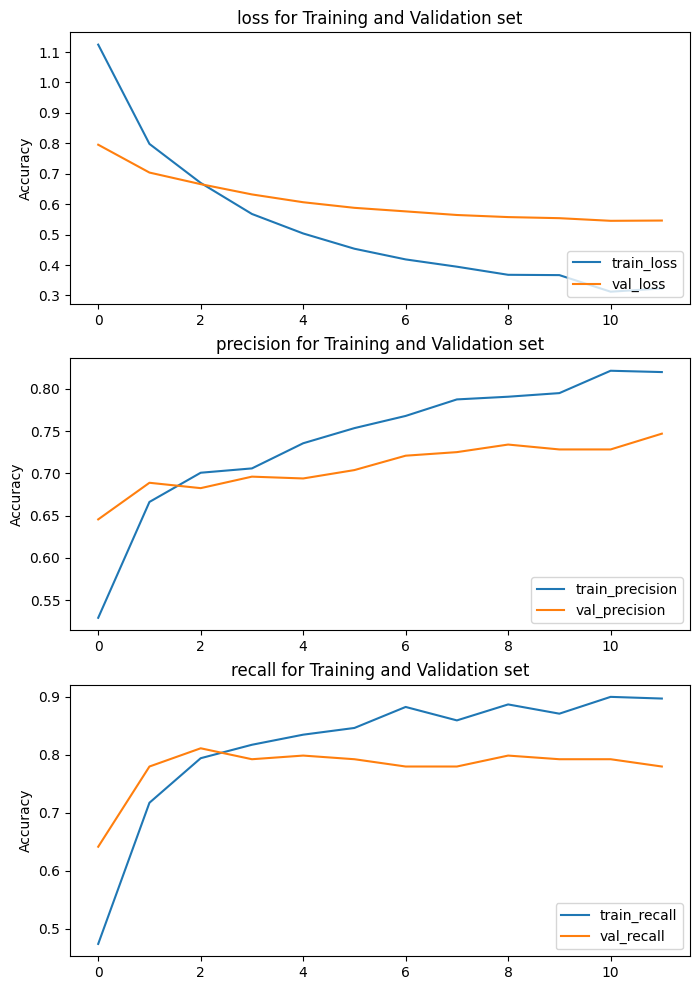

In [237]:
visualize(history)

In [251]:
y_train_pred = model_predict_v2(model, ds_train)
y_valid_pred = model_predict_v2(model, ds_valid)

1/1 [==============================] - 1s 645ms/step
Accuracy Scores on Training Set
Confusion Matrix : [[581   108]]
                   [[55   635]]
Accuracy Score : 0.8817984046410442
** Precision Score : 0.8546433378196501 **
Recall Score : 0.9202898550724637
F1 Score : 0.8862526168876483
Accuracy Scores on Validation Set
Confusion Matrix : [[117   42]]
                   [[35   124]]
Accuracy Score : 0.7578616352201258
** Precision Score : 0.7469879518072289 **
Recall Score : 0.779874213836478
F1 Score : 0.763076923076923


In [252]:
accuracy_report(y_train, y_train_pred, dataset_name="Training")
accuracy_report(y_valid, y_valid_pred, dataset_name="Validation")

Accuracy Scores on Training Set
Confusion Matrix : [[581   108]]
                   [[55   635]]
Accuracy Score : 0.8817984046410442
** Precision Score : 0.8546433378196501 **
Recall Score : 0.9202898550724637
F1 Score : 0.8862526168876483
Accuracy Scores on Validation Set
Confusion Matrix : [[117   42]]
                   [[35   124]]
Accuracy Score : 0.7578616352201258
** Precision Score : 0.7469879518072289 **
Recall Score : 0.779874213836478
F1 Score : 0.763076923076923


<u>Error Analysis</u>

Human Level Performance : 98% on accuracy

                 ^
                 |
                10%
                 |

Training Performance : 88% on accuracy

                 ^
                 |
                12%
                 |

Development Performance : 76% on accuracy

We have huge improvement, but can clearly see that the model is **overfit**\
<u>solution</u> : use more regularization, modify model architecture

<a name='4.4.2.2'></a>
- 4.4.2.2)  Adding Dropout

In [36]:
def model_v2_4_modified():
    # ---- image layers ----
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal_and_vertical", name='random_flip'),
            tf.keras.layers.RandomRotation(0.2, name='random_rotation')
        ],
        name='img_augment'
    )
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights=None, # using pre-load weight from previous model
        # input_tensor=processing_input,
        pooling="avg",
    )
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')
    
    base_model.trainable = False
    
    # ---- text layers ----
    # -- processing_txt from previous adapt
    embed_layer = tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_SIZE,
        # mask_zero=True, # use when connecting recurrent layer
        input_length=MAX_TOKEN,
        weights=[word2vec_weights_all[word2vec_idx, :]],
        trainable=False,
        name='txt_embedding'
    )
    embed_flatten = tf.keras.layers.Flatten(name='txt_flatten')
    
    # ---- modeling ----
    input_imgs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_img')
    input_txt = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_txt')
    
    i = data_augmentation(input_imgs)
    i = preprocess_input(i)
    i = base_model(i, training=False)
    t = processing_txt(input_txt)
    t = embed_layer(t)
    t = embed_flatten(t)
    t = tf.keras.layers.Dropout(0.6, name='dropout')(t)
    c = tf.keras.layers.Concatenate(name='img_txt_concat')([i, t])
    outputs = prediction_layer(c)
    
    model = tf.keras.Model([input_imgs, input_txt], outputs, name='model_v2_4')
    
    return model

In [37]:
model = model_v2_4_modified()

model.summary()

Model: "model_v2_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_txt (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 img_augment (Sequential)       (None, 224, 224, 3)  0           ['input_img[0][0]']              
                                                                                                  
 txt_vectorize (TextVectorizati  (None, 25)          0           ['input_txt[0][0]']     

In [38]:
# transfer weight
path = latest_h5(r"model\v2_3_transfer_learning")

previous_model = tf.keras.models.load_model(path)

previous_weights = previous_model.get_layer('mobilenetv2_1.00_224').get_weights()
model.get_layer('mobilenetv2_1.00_224').set_weights(previous_weights) # mobilenet weight

In [43]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

precision_score = keras.metrics.Precision(name="precision")
recall_score = keras.metrics.Recall(name="recall")

metrics = [precision_score, recall_score]

model.compile(loss=loss, metrics=metrics, optimizer=opt)
history = model.fit(ds_train, validation_data=ds_valid, epochs=INITIAL_EPOCH)

Epoch 1/12
44/44 [==============================] - 33s 646ms/step - loss: 1.4520 - precision: 0.5769 - recall: 0.4623 - val_loss: 0.8986 - val_precision: 0.6781 - val_recall: 0.6226
Epoch 2/12
44/44 [==============================] - 27s 614ms/step - loss: 1.1455 - precision: 0.6294 - recall: 0.7014 - val_loss: 0.8421 - val_precision: 0.6962 - val_recall: 0.6918
Epoch 3/12
44/44 [==============================] - 27s 620ms/step - loss: 0.9942 - precision: 0.6601 - recall: 0.7261 - val_loss: 0.7721 - val_precision: 0.6988 - val_recall: 0.7296
Epoch 4/12
44/44 [==============================] - 27s 614ms/step - loss: 0.9603 - precision: 0.6688 - recall: 0.7725 - val_loss: 0.7558 - val_precision: 0.7091 - val_recall: 0.7358
Epoch 5/12
44/44 [==============================] - 27s 615ms/step - loss: 0.8934 - precision: 0.6765 - recall: 0.7638 - val_loss: 0.7390 - val_precision: 0.7160 - val_recall: 0.7296
Epoch 6/12
44/44 [==============================] - 27s 622ms/step - loss: 0.8022 - p

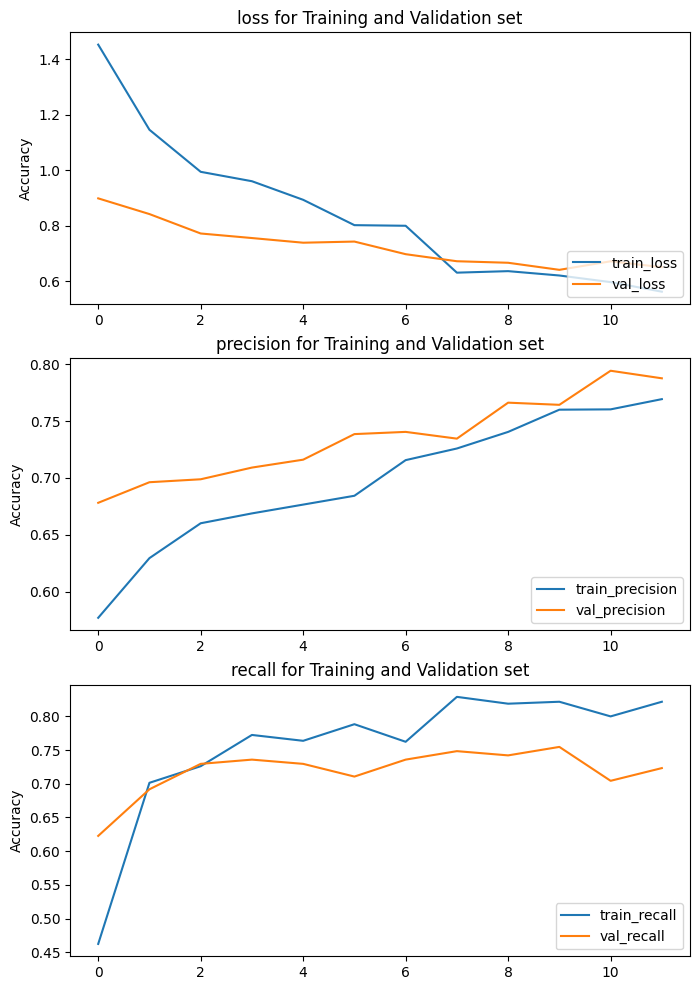

In [44]:
visualize(history)

In [47]:
y_train_pred = model_predict_v2(model, ds_train)
y_valid_pred = model_predict_v2(model, ds_valid)

1/1 [==============================] - 0s 447ms/step


In [48]:
accuracy_report(y_train, y_train_pred, dataset_name="Training")
accuracy_report(y_valid, y_valid_pred, dataset_name="Validation")

Accuracy Scores on Training Set
Confusion Matrix : [[568   121]]
                   [[99   591]]
Accuracy Score : 0.8404641044234953
** Precision Score : 0.8300561797752809 **
Recall Score : 0.8565217391304348
F1 Score : 0.8430813124108416
Accuracy Scores on Validation Set
Confusion Matrix : [[128   31]]
                   [[44   115]]
Accuracy Score : 0.7641509433962265
** Precision Score : 0.7876712328767124 **
Recall Score : 0.7232704402515723
F1 Score : 0.7540983606557377


<a name='4.4.2.3'></a>
- 4.4.2.3) Model Final Version

In [86]:
def model_v2_4_final():
    # ---- image layers ----
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal_and_vertical", name='random_flip'),
            tf.keras.layers.RandomRotation(0.2, name='random_rotation')
        ],
        name='img_augment'
    )
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights=None, # using pre-load weight from previous model
        # input_tensor=processing_input,
        pooling="avg",
    )
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')
    
    base_model.trainable = False
    
    # ---- text layers ----
    # -- processing_txt from previous adapt
    embed_layer = tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_SIZE,
        # mask_zero=True, # use when connecting recurrent layer
        input_length=MAX_TOKEN,
        weights=[word2vec_weights_all[word2vec_idx, :]],
        trainable=False,
        name='txt_embedding'
    )
    embed_flatten = tf.keras.layers.Flatten(name='txt_flatten')
    
    # ---- modeling ----
    input_imgs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_img')
    input_txt = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_txt')
    
    i = data_augmentation(input_imgs)
    i = preprocess_input(i)
    i = base_model(i, training=False)
    i = tf.keras.layers.Dense(16, activation='relu', name='img_dense')(i)
    t = processing_txt(input_txt)
    t = embed_layer(t)
    t = embed_flatten(t)
    t = tf.keras.layers.Dropout(0.6, name='dropout')(t)
    t = tf.keras.layers.Dense(16, activation='relu', name='txt_dense')(t)
    c = tf.keras.layers.Concatenate(name='img_txt_concat')([i, t])
    outputs = prediction_layer(c)
    
    model = tf.keras.Model([input_imgs, input_txt], outputs, name='model_v2_4')
    
    return model

In [90]:
model = model_v2_4_final()

model.summary()

Model: "model_v2_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_txt (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 img_augment (Sequential)       (None, 224, 224, 3)  0           ['input_img[0][0]']              
                                                                                                  
 txt_vectorize (TextVectorizati  (None, 25)          0           ['input_txt[0][0]']     

In [91]:
# transfer weight
path = latest_h5(r"model\v2_3_transfer_learning")

previous_model = tf.keras.models.load_model(path)

previous_weights = previous_model.get_layer('mobilenetv2_1.00_224').get_weights()
model.get_layer('mobilenetv2_1.00_224').set_weights(previous_weights) # mobilenet weight

In [92]:
def lr_step_decay(epoch, lr):
    drop_rate = 0.7
    epochs_drop = 3
    return INITIAL_LEARNING_RATE * math.pow(drop_rate, math.floor(epoch/epochs_drop))

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', min_delta=.01, patience=3, verbose=1,
    mode='max', restore_best_weights=True, start_from_epoch=3
)
learning_rate = tf.keras.callbacks.LearningRateScheduler(
    lr_step_decay, verbose=1
)

precision_score = keras.metrics.Precision(name="precision")
recall_score = keras.metrics.Recall(name="recall")

metrics = [precision_score, recall_score]

model.compile(loss=loss, metrics=metrics, optimizer=opt)
history = model.fit(ds_train, validation_data=ds_valid, epochs=10, callbacks=[early_stopping, learning_rate])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/10
44/44 [==============================] - 47s 981ms/step - loss: 1.0403 - precision: 0.4918 - recall: 0.3478 - val_loss: 0.6966 - val_precision: 0.7586 - val_recall: 0.4151 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/10
44/44 [==============================] - 42s 947ms/step - loss: 0.7062 - precision: 0.6991 - recall: 0.6464 - val_loss: 0.6088 - val_precision: 0.7591 - val_recall: 0.6541 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/10
44/44 [==============================] - 41s 943ms/step - loss: 0.5837 - precision: 0.7417 - recall: 0.7449 - val_loss: 0.5528 - val_precision: 0.7419 - val_recall: 0.7233 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 7e-05.
Epoch 4/10
44/44 [==============================] - 42s 951ms/step - loss: 0.5219 - precision: 0.7507 - recall: 0.7986 - val_loss: 0.5437 - v

In [95]:
model_h5_filename = "model_weight_{}".format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
save_path = os.path.join("model", "v2_4_transfer_learning_with_txt", model_h5_filename)

if not os.path.exists(os.path.dirname(save_path)):
    # make dir if not exists
    os.makedirs(os.path.dirname(save_path))

model.save(save_path, save_format='tf')
print("model saved at : {}".format(save_path))

INFO:tensorflow:Assets written to: model\v2_4_transfer_learning_with_txt\model_weight_2023_02_27_11_03_52\assets


INFO:tensorflow:Assets written to: model\v2_4_transfer_learning_with_txt\model_weight_2023_02_27_11_03_52\assets


model saved at : model\v2_4_transfer_learning_with_txt\model_weight_2023_02_27_11_03_52


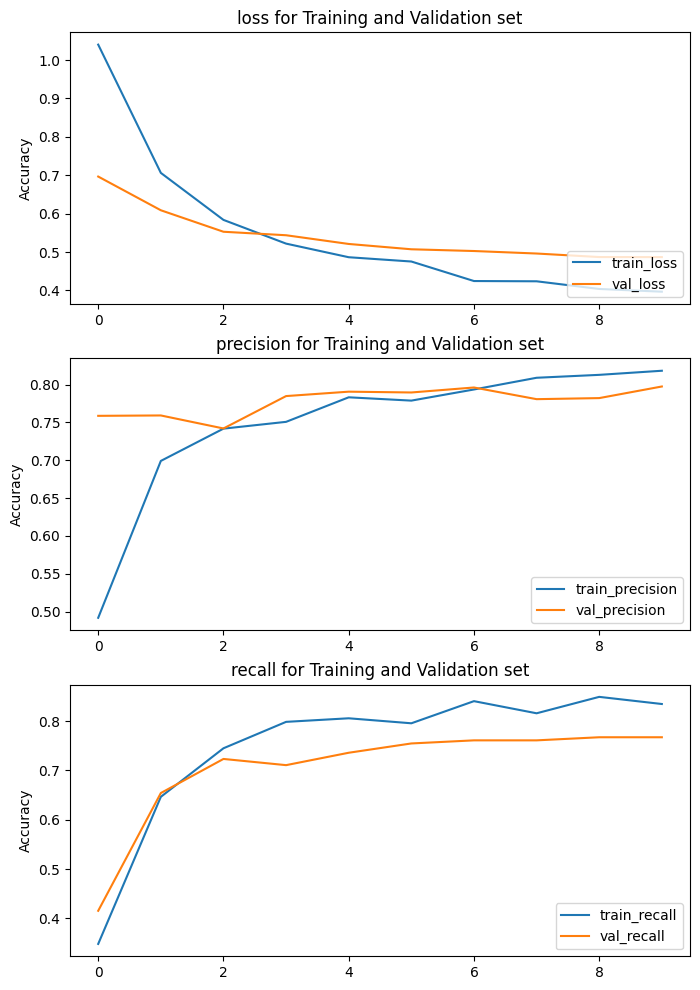

In [93]:
visualize(history)

In [96]:
y_train_pred = model_predict_v2(model, ds_train)
y_valid_pred = model_predict_v2(model, ds_valid)

1/1 [==============================] - 1s 885ms/step


In [97]:
accuracy_report(y_train, y_train_pred, dataset_name="Training")
accuracy_report(y_valid, y_valid_pred, dataset_name="Validation")

Accuracy Scores on Training Set
Confusion Matrix : [[600   89]]
                   [[112   578]]
Accuracy Score : 0.8542422044960116
** Precision Score : 0.8665667166416792 **
Recall Score : 0.8376811594202899
F1 Score : 0.8518791451731761
Accuracy Scores on Validation Set
Confusion Matrix : [[128   31]]
                   [[38   121]]
Accuracy Score : 0.7830188679245284
** Precision Score : 0.7960526315789473 **
Recall Score : 0.7610062893081762
F1 Score : 0.7781350482315114


<a name='4.4.3'></a>
**4.4.3) Pre-trained Embedding layer (from Word2Vec model) with GRU units**

In [39]:
TXT_MAX_LENGTH = int(df_train_processed.description.str.split(" ").str.len().max())

# load processed txt data
txt_data = df_train_processed['description'].values.reshape(-1, 1)
ds_train_txt = tf.data.Dataset.from_tensor_slices(txt_data)

In [40]:
# adapt txt data with TextVectorization layer
processing_txt_recurrent = tf.keras.layers.TextVectorization(
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=TXT_MAX_LENGTH,
    name='txt_vectorize'
)
processing_txt_recurrent.adapt(ds_train_txt.batch(BATCH_SIZE))

# vocab
vocab = processing_txt_recurrent.get_vocabulary()

In [41]:
# embedding weights
word2vec_weights_all = np.concatenate([np.zeros(shape=(1, EMBED_SIZE), dtype=np.float32), word2vec_model.vectors], axis=0)
word2vec_map = dict(map(lambda key_value: (key_value[0], key_value[1] + 1), word2vec_model.key_to_index.items()))

word2vec_idx = [0 if (word in ('', '[UNK]')) or (word not in word2vec_map) else word2vec_map[word] for word in vocab] # padding should be weight 0

In [42]:
VOCAB_SIZE = len(vocab)
EMBED_SIZE = int(word2vec_model.vectors.shape[1])
MAX_TOKEN = len_.quantile(.95)

In [131]:
def model_v2_5():
    # ---- image layers ----
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal_and_vertical", name='random_flip'),
            tf.keras.layers.RandomRotation(0.2, name='random_rotation')
        ],
        name='img_augment'
    )
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights=None, # using pre-load weight from previous model
        # input_tensor=processing_input,
        pooling="avg",
    )
    # prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')
    prediction_layer = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(1, name='output_dense'),
            tf.keras.layers.BatchNormalization(name='output_bn'),
            tf.keras.layers.Activation(activation='sigmoid', name='output_activation')
        ],
        name='output'
    )
    
    base_model.trainable = False
    
    # ---- text layers ----
    # -- processing_txt from previous adapt
    embed_layer = tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBED_SIZE,
        mask_zero=True, # use when connecting recurrent layer
        input_length=MAX_TOKEN,
        weights=[word2vec_weights_all[word2vec_idx, :]],
        trainable=False,
        name='txt_embedding'
    )
    recurrent = tf.keras.layers.GRU(16, name='txt_recurrent', kernel_regularizer='l2', recurrent_regularizer='l2')
    
    # ---- modeling ----
    input_imgs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_img')
    input_txt = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_txt')
    
    i = data_augmentation(input_imgs)
    i = preprocess_input(i)
    i = base_model(i, training=False)
    # i = tf.keras.layers.Dropout(0.2, name='dropout')(i)
    i = tf.keras.layers.Dense(16, activation='relu', name='img_dense')(i)
    t = processing_txt_recurrent(input_txt)
    t = embed_layer(t)
    t = recurrent(t)
    c = tf.keras.layers.Concatenate(name='img_txt_concat')([i, t])
    # c = tf.keras.layers.Dropout(0.2, name='dropout')(c)
    outputs = prediction_layer(c)
    
    model = tf.keras.Model([input_imgs, input_txt], outputs, name='model_v2_5')
    
    return model

In [140]:
model = model_v2_5()

model.summary()

Model: "model_v2_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augment (Sequential)       (None, 224, 224, 3)  0           ['input_img[0][0]']              
                                                                                                  
 tf.math.truediv_21 (TFOpLambda  (None, 224, 224, 3)  0          ['img_augment[0][0]']            
 )                                                                                                
                                                                                         

In [141]:
# transfer weight
path = latest_h5(r"model\v2_3_transfer_learning")

previous_model = tf.keras.models.load_model(path)

previous_weights = previous_model.get_layer('mobilenetv2_1.00_224').get_weights()
model.get_layer('mobilenetv2_1.00_224').set_weights(previous_weights) # mobilenet weight

<a name='4.4.3.1'></a>
- 4.4.3.1) Checkpoint

In [142]:
# def lr_step_decay(epoch, lr):
#     if epoch < 2:
#         return 0.0002
#     else:
#         return 0.0001

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_precision', min_delta=.01, patience=3, verbose=1,
#     mode='max', restore_best_weights=True, start_from_epoch=3
# )
# learning_rate = tf.keras.callbacks.LearningRateScheduler(
#     lr_step_decay, verbose=1
# )

precision_score = keras.metrics.Precision(name="precision")
recall_score = keras.metrics.Recall(name="recall")

metrics = [precision_score, recall_score]

model.compile(loss=loss, metrics=metrics, optimizer=opt)
history = model.fit(ds_train, validation_data=ds_valid, epochs=10, callbacks=[])

Epoch 1/10
44/44 [==============================] - 79s 2s/step - loss: 1.7021 - precision: 0.5916 - recall: 0.6130 - val_loss: 1.6162 - val_precision: 0.6696 - val_recall: 0.4843
Epoch 2/10
44/44 [==============================] - 77s 2s/step - loss: 1.5667 - precision: 0.6733 - recall: 0.6870 - val_loss: 1.5427 - val_precision: 0.7155 - val_recall: 0.5220
Epoch 3/10
44/44 [==============================] - 76s 2s/step - loss: 1.4802 - precision: 0.7109 - recall: 0.7058 - val_loss: 1.4751 - val_precision: 0.7544 - val_recall: 0.5409
Epoch 4/10
44/44 [==============================] - 73s 2s/step - loss: 1.4239 - precision: 0.7237 - recall: 0.6986 - val_loss: 1.4163 - val_precision: 0.7583 - val_recall: 0.5723
Epoch 5/10
44/44 [==============================] - 74s 2s/step - loss: 1.3606 - precision: 0.7643 - recall: 0.7377 - val_loss: 1.3616 - val_precision: 0.7594 - val_recall: 0.6352
Epoch 6/10
44/44 [==============================] - 68s 2s/step - loss: 1.3069 - precision: 0.7756 -

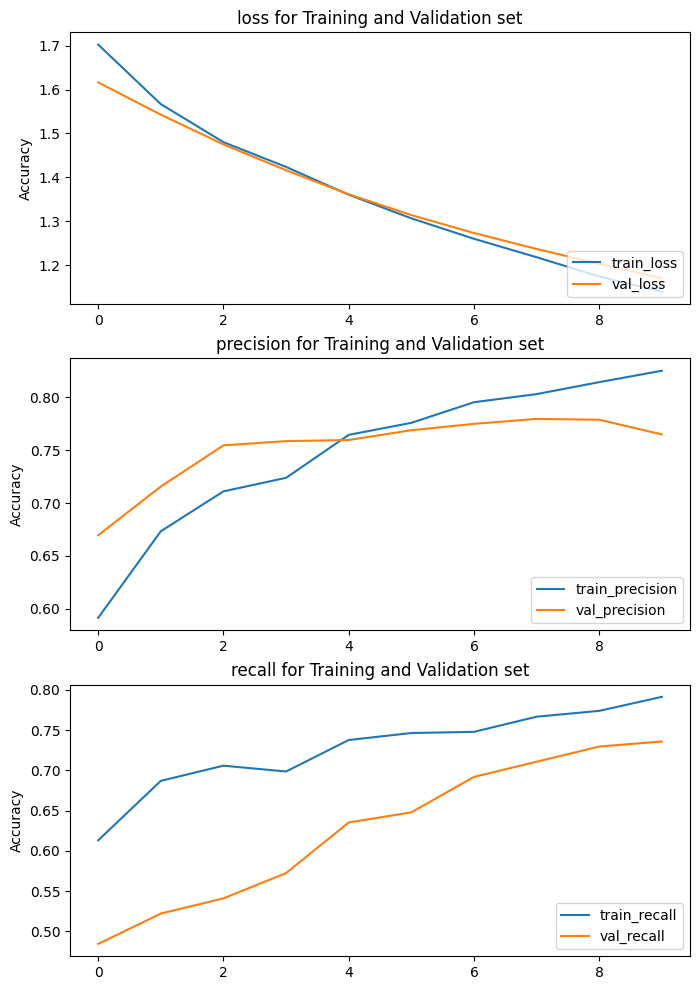

In [143]:
visualize(history)

In [144]:
# check point
model_h5_filename = "model_ceckpoint_{}".format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
save_path = os.path.join("model", "v2_5_transfer_learning_with_txt", model_h5_filename)

if not os.path.exists(os.path.dirname(save_path)):
    # make dir if not exists
    os.makedirs(os.path.dirname(save_path))

model.save(save_path, save_format='tf')
print("model saved at : {}".format(save_path))

INFO:tensorflow:Assets written to: model\v2_5_transfer_learning_with_txt\model_ceckpoint_2023_02_28_12_58_26\assets


INFO:tensorflow:Assets written to: model\v2_5_transfer_learning_with_txt\model_ceckpoint_2023_02_28_12_58_26\assets


model saved at : model\v2_5_transfer_learning_with_txt\model_ceckpoint_2023_02_28_12_58_26


<a name='4.4.3.2'></a>
- 4.4.3.2) Final Version (continue from checkpoint)

In [147]:
# def lr_step_decay(epoch, lr):
#     if epoch < 2:
#         return 0.0002
#     else:
#         return 0.0001

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE/2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', min_delta=.01, patience=2, verbose=1,
    mode='max', restore_best_weights=True, start_from_epoch=0
)
# learning_rate = tf.keras.callbacks.LearningRateScheduler(
#     lr_step_decay, verbose=1
# )

precision_score = keras.metrics.Precision(name="precision")
recall_score = keras.metrics.Recall(name="recall")

metrics = [precision_score, recall_score]

model.compile(loss=loss, metrics=metrics, optimizer=opt)
history = model.fit(ds_train, validation_data=ds_valid, epochs=10, callbacks=[early_stopping])

Epoch 1/10


44/44 [==============================] - 85s 2s/step - loss: 1.1102 - precision: 0.8240 - recall: 0.8072 - val_loss: 1.1503 - val_precision: 0.7580 - val_recall: 0.7484
Epoch 2/10
44/44 [==============================] - 86s 2s/step - loss: 1.0858 - precision: 0.8398 - recall: 0.7899 - val_loss: 1.1318 - val_precision: 0.7547 - val_recall: 0.7547
Epoch 3/10
44/44 [==============================] - 88s 2s/step - loss: 1.0634 - precision: 0.8417 - recall: 0.8014 - val_loss: 1.1137 - val_precision: 0.7610 - val_recall: 0.7610
Epoch 3: early stopping


In [148]:
y_train_pred = model_predict_v2(model, ds_train)
y_valid_pred = model_predict_v2(model, ds_valid)

1/1 [==============================] - 1s 1s/step


In [149]:
accuracy_report(y_train, y_train_pred, dataset_name="Training")
accuracy_report(y_valid, y_valid_pred, dataset_name="Validation")

Accuracy Scores on Training Set
Confusion Matrix : [[577   112]]
                   [[143   547]]
Accuracy Score : 0.8150833937635968
** Precision Score : 0.8300455235204856 **
Recall Score : 0.7927536231884058
F1 Score : 0.8109710896960711
Accuracy Scores on Validation Set
Confusion Matrix : [[121   38]]
                   [[40   119]]
Accuracy Score : 0.7547169811320755
** Precision Score : 0.7579617834394905 **
Recall Score : 0.7484276729559748
F1 Score : 0.7531645569620252


In [150]:
# check point
model_h5_filename = "model_final_{}".format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
save_path = os.path.join("model", "v2_5_transfer_learning_with_txt", model_h5_filename)

if not os.path.exists(os.path.dirname(save_path)):
    # make dir if not exists
    os.makedirs(os.path.dirname(save_path))

model.save(save_path, save_format='tf')
print("model saved at : {}".format(save_path))

INFO:tensorflow:Assets written to: model\v2_5_transfer_learning_with_txt\model_final_2023_02_28_13_27_39\assets


INFO:tensorflow:Assets written to: model\v2_5_transfer_learning_with_txt\model_final_2023_02_28_13_27_39\assets


model saved at : model\v2_5_transfer_learning_with_txt\model_final_2023_02_28_13_27_39


<a name='5'></a>
# 5 Model Selection (Summary)

<a href='#home'>content</a>

From each experiments, we can summarize all experimental results for each version of model within the following table

<h4 align="center">Model Accuracy Summary</h4>

|Model Ver.|Details|Dataset Type|Confusion Matrix|Accuracy|Precision|Recall|F1 Score|
|:-----------:|:-----|:----------:|:--------------:|:------:|:-------:|:----:|:------:|
|Version 1|Transfer Learning (MobileNet) for image classification, <br /> add new classification layer for training|Training|<table><thead><tr><th></th><th>Pred:0</th><th>Pred:1</th></tr></thead><tbody><tr><td><b>True:0</b></td><td>466</td><td>223</td></tr><tr><td><b>True:1</b></td><td>237</td><td>453</td></tr></tbody></table>|66.64%|67.01%|65.65%|66.32%|
|||Validation|<table><thead><tr><th></th><th>Pred:0</th><th>Pred:1</th></tr></thead><tbody><tr><td><b>True:0</b></td><td>111</td><td>48</td></tr><tr><td><b>True:1</b></td><td>62</td><td>97</td></tr></tbody></table>|65.41%|<b>66.90% \*\*</b>|61.01%|63.82%|
|Version 2|Transfer Learning (MobileNet) for image classification, <br /> unfreeze last Convolution layer for training|Training|<table><thead><tr><th></th><th>Pred:0</th><th>Pred:1</th></tr></thead><tbody><tr><td><b>True:0</b></td><td>501</td><td>188</td></tr><tr><td><b>True:1</b></td><td>233</td><td>457</td></tr></tbody></table>|69.47%|70.85%|66.23%|68.46%|
|||Validation|<table><thead><tr><th></th><th>Pred:0</th><th>Pred:1</th></tr></thead><tbody><tr><td><b>True:0</b></td><td>114</td><td>45</td></tr><tr><td><b>True:1</b></td><td>55</td><td>104</td></tr></tbody></table>|68.55%|<b>70.00% \*\*</b>|65.41%|67.53%|
|Version 3|Transfer Learning (MobileNet) for image classification, <br /> unfreeze last 2 blocks and Convolution layer for training|Training|<table><thead><tr><th></th><th>Pred:0</th><th>Pred:1</th></tr></thead><tbody><tr><td><b>True:0</b></td><td>478</td><td>211</td></tr><tr><td><b>True:1</b></td><td>188</td><td>502</td></tr></tbody></table>|71.07%|70.41%|72.75%|71.56%|
|||Validation|<table><thead><tr><th></th><th>Pred:0</th><th>Pred:1</th></tr></thead><tbody><tr><td><b>True:0</b></td><td>109</td><td>50</td></tr><tr><td><b>True:1</b></td><td>44</td><td>115</td></tr></tbody></table>|70.44%|<b>70.00% \*\*</b>|72.33%|70.99%|
|Version 4|Transfer Learning for both image (MobileNet) and text <br /> (Word2Vec), <br /> flatten embedding layer and add hidden layer for training|Training|<table><thead><tr><th></th><th>Pred:0</th><th>Pred:1</th></tr></thead><tbody><tr><td><b>True:0</b></td><td>600</td><td>80</td></tr><tr><td><b>True:1</b></td><td>112</td><td>578</td></tr></tbody></table>|85.42%|86.66%|83.77%|85.19%|
|||Validation|<table><thead><tr><th></th><th>Pred:0</th><th>Pred:1</th></tr></thead><tbody><tr><td><b>True:0</b></td><td>128</td><td>21</td></tr><tr><td><b>True:1</b></td><td>31</td><td>121</td></tr></tbody></table>|78.30%|<b>79.61% \*\*</b>|76.10%|77.81%|
|Version 5|Transfer Learning for both image (MobileNet) and text <br /> (Word2Vec), <br /> add recurrent layer after word embedding for training|Training|<table><thead><tr><th></th><th>Pred:0</th><th>Pred:1</th></tr></thead><tbody><tr><td><b>True:0</b></td><td>577</td><td>112</td></tr><tr><td><b>True:1</b></td><td>143</td><td>547</td></tr></tbody></table>|81.51%|83.00%|79.28%|81.10%|
|||Validation|<table><thead><tr><th></th><th>Pred:0</th><th>Pred:1</th></tr></thead><tbody><tr><td><b>True:0</b></td><td>128</td><td>21</td></tr><tr><td><b>True:1</b></td><td>31</td><td>121</td></tr></tbody></table>|75.47%|<b>75.80% \*\*</b>|74.84%|75.32%|

From the table, **model version 4** yields the highest accuracy (precision) on validation set. Therefore, we gonna choose model 4 as our final model for prediction

<a name='6'></a>
# 6 Model Evaluation (Testing Set)

<a href='#home'>content</a>

In [154]:
# transfer weight
path = latest_h5(r"model\v2_4_transfer_learning_with_txt")

final_model = tf.keras.models.load_model(path)

In [155]:
y_test_pred = model_predict_v2(model, ds_test)

1/1 [==============================] - 1s 1s/step


In [156]:
accuracy_report(y_valid, y_valid_pred, dataset_name="Testing")

Accuracy Scores on Testing Set
Confusion Matrix : [[121   38]]
                   [[40   119]]
Accuracy Score : 0.7547169811320755
** Precision Score : 0.7579617834394905 **
Recall Score : 0.7484276729559748
F1 Score : 0.7531645569620252


<a name='7'></a>
# 7 Model Prediction

<a href='#home'>content</a>

In [199]:
path = os.path.join(SOURCE_DIR, TEST_PREDICT_FILENAME)

df_predict = pd.read_csv(path, index_col=0)
df_predict.head()

,description
PromotionId,
1NWLA8yFGO4oZeRpAvdAY1JDJb6UtA,โปรโมชั่นพิเศษสำหรับ นักเรียน นักศึกษา เพียง แ...
1NWLAsDec3ZqmKAKk8cOgDmg5dVwuQ,ส่วนลด 10 บาททันที สำหรับลูกค้าในการซื้อแก้วแรก
1NWLAA6FbijUl5mqQ0Z2VTetfFlmRX,NaN
1NWLCX8ML1e2c5pkgf8oT1AVfAsFio,LINEMAN บริการส่งเค้กถึงมือท่าน
1NWLC0j3XRIwoXpTNXFkZVah0bnasd,2 วันสุดท้ายของเดือนนี้\n\n\n30-31 สค 61


In [201]:
df_predict_processed = preprocess_text(
    df_predict, mode="Inference", 
    custom_th_words=domain_words_th, custom_en_words=domain_words_eng, stopwords=stopwords
)

df_predict_processed.head()

C:\Users\11413929\AppData\Local\Temp\ipykernel_7084\3761946930.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng['valid'] = df_eng.description.isin(valid_words_eng) | df_eng.description.isin(custom_eng_words)


,PromotionId,description
0,1NWLA8yFGO4oZeRpAvdAY1JDJb6UtA,โปรโมชั่น พิเศษ สำหรับ นักเรียน นักศึกษา บัตรป...
1,1NWLAsDec3ZqmKAKk8cOgDmg5dVwuQ,ส่วนลด บาท สำหรับ ลูกค้า ซื้อ แก้ว
2,1NWLAA6FbijUl5mqQ0Z2VTetfFlmRX,
3,1NWLCX8ML1e2c5pkgf8oT1AVfAsFio,lineman บริการ เค้ก มือ ท่าน
4,1NWLC0j3XRIwoXpTNXFkZVah0bnasd,วันสุดท้าย เดือน บาท สิงหาคม


In [213]:
ds_inference = get_images_txt(df_predict_processed, folder=TEST_IMG_FOLDER)

prediction = model_predict_v2(model, ds_inference, mode="Inference")

1/1 [==============================] - 1s 1s/step


In [221]:
inference_results = pd.merge(
    df_predict_processed.drop(columns='description'), df_predict, left_on='PromotionId', right_on='PromotionId',
    how='inner'
)
inference_results['predict'] = prediction

inference_results.head()

,PromotionId,description,predict
0,1NWLA8yFGO4oZeRpAvdAY1JDJb6UtA,โปรโมชั่นพิเศษสำหรับ นักเรียน นักศึกษา เพียง แ...,0
1,1NWLAsDec3ZqmKAKk8cOgDmg5dVwuQ,ส่วนลด 10 บาททันที สำหรับลูกค้าในการซื้อแก้วแรก,0
2,1NWLAA6FbijUl5mqQ0Z2VTetfFlmRX,NaN,1
3,1NWLCX8ML1e2c5pkgf8oT1AVfAsFio,LINEMAN บริการส่งเค้กถึงมือท่าน,0
4,1NWLC0j3XRIwoXpTNXFkZVah0bnasd,2 วันสุดท้ายของเดือนนี้\n\n\n30-31 สค 61,0


In [283]:
%matplotlib inline
def display_prediction(promotion_id, img_ref, df_ref):
    def predict_label(label):
        if label == 1:
            return "spam"
        else:
            return "not spam"
    
    pos = df_ref[df_ref.PromotionId == promotion_id].index[0]
    # get img
    for i, (img, txt_prep) in enumerate(ds_ref.as_numpy_iterator()):
        if i == pos:
            img_display = img[0]
            break
    # get description
    description = df_ref.loc[pos, 'description']
    if not isinstance(description, str):
        description = "-"
    # get prediction
    prediction = df_ref.loc[pos, 'predict']
    
    # display
    print("Promotion Id : {}".format(promotion_id))
    print("\n====== Promotion Image ======")
    plt.imshow(img_display.astype('int'))
    plt.axis("off")
    plt.show()
    print("\n====== Promotion Description ======")
    print("\n{}".format(description))
    print("\n\nPrediction : {}".format(predict_label(prediction)))

In [278]:
ds_ref = ds_inference.unbatch()

Promotion Id : 1NWLA8yFGO4oZeRpAvdAY1JDJb6UtA

====== Promotion Image ======


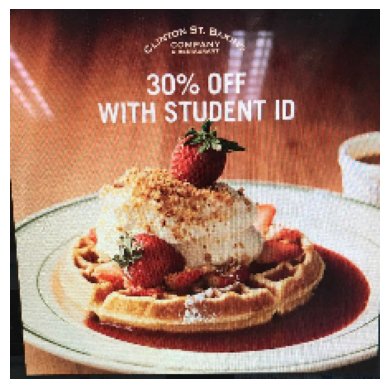


====== Promotion Description ======

โปรโมชั่นพิเศษสำหรับ นักเรียน นักศึกษา เพียง แสดงบัตรประจำตัว รับส่วนลดทันที 30%


Prediction : not spam


In [284]:
display_prediction("1NWLA8yFGO4oZeRpAvdAY1JDJb6UtA", ds_ref, inference_results)

Promotion Id : 1NWLAA6FbijUl5mqQ0Z2VTetfFlmRX

====== Promotion Image ======


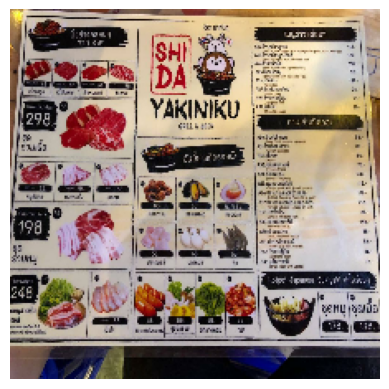


====== Promotion Description ======

-


Prediction : spam


In [285]:
display_prediction("1NWLAA6FbijUl5mqQ0Z2VTetfFlmRX", ds_ref, inference_results)

# Thank You !!